# Оптимизация производственных расходов на металлургическом комбинате "Стальная птица"

Одним из технологических процессов, входящих в цикл деятельности предприятия "Стальная птица", является обработка стали. Для этого используется многостадийный процесс, включающий в себя в том числе
нагрев исходного материала и измерение его температуры. Это в свою
очередь требует подвода электроэнергии, величину которой
можно оптимизировать. 

**Целью** данного проекта будет являться **построение модели машинного обучения**, которая позволит осуществлять **предсказание температуры** используемого сплава. Метрикой качества разрабатываемой модели будет являться MAE - средняя абсолютная ошибка, которую в данном контексте можно трактовать как отклонение предсказываемой температуры от реальной в градусах. Поставленная задача - достичь MAE <= 6.8.

Для решения поставленой задачи необходимо изучить исходные данные, провести их предварительную обработку, сделать выводы о том, какие из них можно использовать для обучения. Также необходимо исследовать представленные данные на наличие пропусков, аномалий, корреляций и других характеристик, которые могут сказаться на обучении. Для этого мы изучим их распределения, взаимосвязь, а также проведем (при необходимости) масштабирование и кодирование данных для последующего встраивания в выбранную модель. 

Данные состоят из нескольких файлов, полученных из разных источников:<br>
**data_arc_new.csv** — данные об электродах;<br>
**data_bulk_new.csv** — данные о подаче сыпучих материалов (объём);<br>
**data_bulk_time_new.csv** — данные о подаче сыпучих материалов (время);<br>
**data_gas_new.csv** — данные о продувке сплава газом; <br>
**data_temp_new.csv** — результаты измерения температуры; <br>
**data_wire_new.csv** — данные о проволочных материалах (объём); <br>
**data_wire_time_new.csv** — данные о проволочных материалах (время).

Для построения моделей мы разделим исходную выборку на тренировочную и тестовую, на которой исследуем параметры качества. Из обученных моделей выберем наиболее подходящую, на которой и проверим необходимое качество. 

Описанные результаты исследования представим в выводе о проделанной работе и сформулируем ряд рекомендаций для бизнеса. 

Предварительно импортируем все используемые в проекте библиотеки. 

In [1]:
import pandas as pd
import os
import matplotlib.colors as cm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (mean_absolute_error, make_scorer)
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

## 1. Загрузка данных

Загрузим в соответствующие датафреймы библиотеки pandas необходимые файлы с исходными данными

In [2]:
#Загрузка данных
pth1 = 'data_arc_new.csv'
pth2 = '/datasets/data_arc_new.csv'
pth3 = 'data_bulk_new.csv'
pth4 = '/datasets/data_bulk_new.csv'
pth5 = 'data_bulk_time_new.csv'
pth6 = '/datasets/data_bulk_time_new.csv'
pth7 = 'data_gas_new.csv '
pth8 = '/datasets/data_gas_new.csv'
pth9 = 'data_temp_new.csv'
pth10 = '/datasets/data_temp_new.csv'
pth11 = 'data_wire_new.csv'
pth12 = '/datasets/data_wire_new.csv'
pth13 = 'data_wire_time_new.csv'
pth14 = '/datasets/data_wire_time_new.csv'
if os.path.exists(pth1):
    data_arc = pd.read_csv(pth1)
    data_bulk = pd.read_csv(pth3)
    data_bulk_time = pd.read_csv(pth5)
    data_gas = pd.read_csv(pth7)
    data_temp = pd.read_csv(pth9)
    data_wire = pd.read_csv(pth11)
    data_wire_time = pd.read_csv(pth13)
elif os.path.exists(pth2):
    data_arc = pd.read_csv(pth2)
    data_bulk = pd.read_csv(pth4)
    data_bulk_time = pd.read_csv(pth6)
    data_gas = pd.read_csv(pth8)
    data_temp = pd.read_csv(pth10)
    data_wire = pd.read_csv(pth12)
    data_wire_time = pd.read_csv(pth14)
else:
    print('Something is wrong')

Проведем первичный осмотр данных - определим их структуру, типы используемых данных и тд. 

### 1.1 Данные об электродах

In [3]:
#Выведем первые 10 строк датафрейма о нагревании электродами
data_arc.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


In [4]:
#Выведем основную информацию о представленных данных
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [5]:

print('Число явных дубликатов - ', data_arc.duplicated().sum())

Число явных дубликатов -  0


**Вывод**: из представленного обзора видно, что названия столбцов не соответсвуют стандартным правилам: разные регистры, наличие пробелов, разные языки. Явных пробелов и дубликатов в данных не обнаружено, но возможная определенная оптимизация представленных типов - начало и конец нагрева в тип datetime.  

***

Проведем переименование данных столбцов

In [6]:
data_arc.columns

Index(['key', 'Начало нагрева дугой', 'Конец нагрева дугой',
       'Активная мощность', 'Реактивная мощность'],
      dtype='object')

In [7]:
data_arc = data_arc.rename(columns={'Начало нагрева дугой': 'start_heating', 'Конец нагрева дугой': 'end_heating', 'Активная мощность': 'active_power', 'Реактивная мощность': 'reactive_power'}) 

In [8]:
data_arc.columns

Index(['key', 'start_heating', 'end_heating', 'active_power',
       'reactive_power'],
      dtype='object')

Изменим типы данных столбцов start_heating, end_heating

In [9]:
data_arc['start_heating'] = pd.to_datetime(
    data_arc['start_heating'], format='%Y-%m-%dT%H:%M:%S'
)
data_arc['end_heating'] = pd.to_datetime(
    data_arc['end_heating'], format='%Y-%m-%dT%H:%M:%S'
)

In [10]:
data_arc.dtypes

key                        int64
start_heating     datetime64[ns]
end_heating       datetime64[ns]
active_power             float64
reactive_power           float64
dtype: object

**Вывод**: столбцы данных об электродах приведены к единому правилу наименований, типы данных для столбцов начала и конца нагрева сведение к datetime64.

### 1.2 Данные о подаче сыпучих материалов (объем) 

In [11]:
data_bulk.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


In [12]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [13]:
print('Число явных дубликатов - ', data_bulk.duplicated().sum())

Число явных дубликатов -  0


**Вывод**: из представленного видно, что названия столбцов также написаны не в змеином регистре с присутствием пробелов, в данных большое количество пропусков, которые, по всей видимости, обозначают нулевые значения (отсутствие добавляемого материала), дубликатов же в данных не обнаружено. 

___

Проведем переименование столбцов

In [14]:
data_bulk.columns

Index(['key', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6',
       'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15'],
      dtype='object')

In [15]:
data_bulk = data_bulk.rename(columns = {'Bulk 1':'bulk_1',
                                        'Bulk 2':'bulk_2',
                                        'Bulk 3':'bulk_3',
                                        'Bulk 4':'bulk_4',
                                        'Bulk 5':'bulk_5',
                                        'Bulk 6':'bulk_6',
                                        'Bulk 7':'bulk_7',
                                        'Bulk 8':'bulk_8',
                                        'Bulk 9':'bulk_9',
                                        'Bulk 10':'bulk_10',
                                        'Bulk 11':'bulk_11',
                                        'Bulk 12':'bulk_12',
                                        'Bulk 13':'bulk_13',
                                        'Bulk 14':'bulk_14',
                                        'Bulk 15':'bulk_15'
                                       })

In [16]:
data_bulk.columns

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

In [17]:
data_bulk = data_bulk.fillna(0)
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   3129 non-null   float64
 2   bulk_2   3129 non-null   float64
 3   bulk_3   3129 non-null   float64
 4   bulk_4   3129 non-null   float64
 5   bulk_5   3129 non-null   float64
 6   bulk_6   3129 non-null   float64
 7   bulk_7   3129 non-null   float64
 8   bulk_8   3129 non-null   float64
 9   bulk_9   3129 non-null   float64
 10  bulk_10  3129 non-null   float64
 11  bulk_11  3129 non-null   float64
 12  bulk_12  3129 non-null   float64
 13  bulk_13  3129 non-null   float64
 14  bulk_14  3129 non-null   float64
 15  bulk_15  3129 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


**Вывод**: в данных по объему сыпучих материалов названия столбцов приведены к единому формату, пропущенные значения заменены нулевыми. 

### 1.3 Данные о подаче сыпучих материалов (время) 

In [18]:
data_bulk_time.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47
5,6,NaN,NaN,NaN,2019-05-03 13:57:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:48:52,NaN,2019-05-03 14:09:42,2019-05-03 14:03:15
6,7,NaN,NaN,NaN,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:41:26,NaN,2019-05-03 14:30:50,2019-05-03 14:27:16
7,8,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,2019-05-03 15:13:18,2019-05-03 15:05:33
8,9,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,2019-05-03 16:00:16,2019-05-03 15:52:39
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:38:11,NaN,2019-05-03 16:34:24,2019-05-03 16:29:56


In [19]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [20]:
print('Число явных дубликатов - ', data_bulk_time.duplicated().sum())

Число явных дубликатов -  0


**Вывод**: аналогично предыдущему в данных имеются пропуски, которые могут быть связаны с отсутствием добавляемого материала. Тип данных требует оптимизации - приведение всех object к типу datetime, столбцы также нуждаются в переименовании.

___

Устраним обозначенные проблемы

In [21]:
data_bulk_time = data_bulk_time.rename(columns = {'Bulk 1':'bulk_1',
                                        'Bulk 2':'bulk_2',
                                        'Bulk 3':'bulk_3',
                                        'Bulk 4':'bulk_4',
                                        'Bulk 5':'bulk_5',
                                        'Bulk 6':'bulk_6',
                                        'Bulk 7':'bulk_7',
                                        'Bulk 8':'bulk_8',
                                        'Bulk 9':'bulk_9',
                                        'Bulk 10':'bulk_10',
                                        'Bulk 11':'bulk_11',
                                        'Bulk 12':'bulk_12',
                                        'Bulk 13':'bulk_13',
                                        'Bulk 14':'bulk_14',
                                        'Bulk 15':'bulk_15'
                                       })
data_bulk_time.columns

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

In [22]:
data_bulk_time = data_bulk_time.fillna(0)

In [23]:
for column in data_bulk_time.columns:
    if (column != 'key'):
        data_bulk_time[column] = pd.to_datetime(
            data_bulk_time[column], format='%Y-%m-%dT%H:%M:%S'
        )
#

In [24]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   bulk_1   3129 non-null   datetime64[ns]
 2   bulk_2   3129 non-null   datetime64[ns]
 3   bulk_3   3129 non-null   datetime64[ns]
 4   bulk_4   3129 non-null   datetime64[ns]
 5   bulk_5   3129 non-null   datetime64[ns]
 6   bulk_6   3129 non-null   datetime64[ns]
 7   bulk_7   3129 non-null   datetime64[ns]
 8   bulk_8   3129 non-null   datetime64[ns]
 9   bulk_9   3129 non-null   datetime64[ns]
 10  bulk_10  3129 non-null   datetime64[ns]
 11  bulk_11  3129 non-null   datetime64[ns]
 12  bulk_12  3129 non-null   datetime64[ns]
 13  bulk_13  3129 non-null   datetime64[ns]
 14  bulk_14  3129 non-null   datetime64[ns]
 15  bulk_15  3129 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


**Вывод**: в данных о времени для сыпучих материалов столбцы приведены к единым правилам названий, пропущенные значения заменены нулевыми, типы данных приведены к datetime.

### 1.4 Данные о продувке газом 

In [25]:
data_gas.head(10)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


In [26]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [27]:
print('Число явных дубликатов - ', data_gas.duplicated().sum())

Число явных дубликатов -  0


**Вывод**: наименование столбца следует изменить на gas_1.

____

In [28]:
data_gas = data_gas.rename(columns = {'Газ 1':'gas_1'})

In [29]:
data_gas.columns

Index(['key', 'gas_1'], dtype='object')

**Вывод**: пропусков и явных дубликатов в данных о продувке газом не обнаружено, названия столбцов соответсвуют общепринятым.

### 1.5 Данные об измерении температуры

In [30]:
data_temp.head(10)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


In [31]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [32]:
print('Число явных дубликатов - ', data_temp.duplicated().sum())

Число явных дубликатов -  0


**Вывод**: названия столбцов следует привезти к общепринятым, тип данных для времени замера необходимо свести в datetime. Пропущенных значений по температуре достаточно много - порядка 19 процентов от исходных данных. Восстановим их далее при исследовательском анализе данных. 

___

In [33]:
data_temp = data_temp.rename(columns = {'Время замера':'measuring_time', 'Температура': 'temperature'})
data_temp.columns

Index(['key', 'measuring_time', 'temperature'], dtype='object')

In [34]:
data_temp['measuring_time'] = pd.to_datetime(
            data_temp['measuring_time'], format='%Y-%m-%dT%H:%M:%S')

In [35]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             18092 non-null  int64         
 1   measuring_time  18092 non-null  datetime64[ns]
 2   temperature     14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


**Вывод**: названия столбцов в данных об измерении температуры сведены к общепринятым, тип данных о времени измерения преобразован в datetime. Также в дальнейшем требуется обработка пропущенных значений по значениям темперутуры. 

### 1.6 Данные об объеме проволочных материалов

In [36]:
data_wire.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [38]:
print('Число явных дубликатов - ', data_wire.duplicated().sum())

Число явных дубликатов -  0


**Вывод**: названия стобцов не соответсвуют общепринятым, пропущенные значения свидетельствуют об отсутствии в некоторых партиях определенных материалов, явных дубликатов не обнаружено. 

___

In [39]:
data_wire = data_wire.rename(columns = {'Wire 1':'wire_1',
                                        'Wire 2':'wire_2',
                                        'Wire 3':'wire_3',
                                        'Wire 4':'wire_4',
                                        'Wire 5':'wire_5',
                                        'Wire 6':'wire_6',
                                        'Wire 7':'wire_7',
                                        'Wire 8':'wire_8',
                                        'Wire 9':'wire_9',
                                       })
data_wire.columns

Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')

In [40]:
data_wire = data_wire.fillna(0)
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3081 non-null   float64
 2   wire_2  3081 non-null   float64
 3   wire_3  3081 non-null   float64
 4   wire_4  3081 non-null   float64
 5   wire_5  3081 non-null   float64
 6   wire_6  3081 non-null   float64
 7   wire_7  3081 non-null   float64
 8   wire_8  3081 non-null   float64
 9   wire_9  3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


**Вывод**: в данных о проволочных материалах проведено переименование столбцов и пропущенные значения заменены нулевыми. 

### 1.7 Данные о времени проволочных материалов 

In [41]:
data_wire_time.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:57:27,2019-05-03 13:48:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:01:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:45:44,2019-05-03 15:39:37,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:27:00,2019-05-03 16:22:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [43]:
print('Число явных дубликатов - ', data_wire_time.duplicated().sum())

Число явных дубликатов -  0


**Вывод**: проблемы аналогичные в данных по объему проволочных материалов - название столбцов, пропущенные значения. Кроме этого тип данных о времени также требует оптимизации. 

___

In [44]:
data_wire_time = data_wire_time.rename(columns = {'Wire 1':'wire_1',
                                        'Wire 2':'wire_2',
                                        'Wire 3':'wire_3',
                                        'Wire 4':'wire_4',
                                        'Wire 5':'wire_5',
                                        'Wire 6':'wire_6',
                                        'Wire 7':'wire_7',
                                        'Wire 8':'wire_8',
                                        'Wire 9':'wire_9',
                                       })
data_wire_time.columns

Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')

In [45]:
data_wire_time = data_wire_time.fillna(0)

In [46]:
for column in data_wire_time.columns:
    if (column != 'key'):
        data_wire_time[column] = pd.to_datetime(
            data_wire_time[column], format='%Y-%m-%dT%H:%M:%S', errors='ignore'
        )

In [47]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   wire_1  3081 non-null   datetime64[ns]
 2   wire_2  3081 non-null   datetime64[ns]
 3   wire_3  3081 non-null   datetime64[ns]
 4   wire_4  3081 non-null   datetime64[ns]
 5   wire_5  3081 non-null   datetime64[ns]
 6   wire_6  3081 non-null   datetime64[ns]
 7   wire_7  3081 non-null   datetime64[ns]
 8   wire_8  3081 non-null   datetime64[ns]
 9   wire_9  3081 non-null   datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


**Вывод**: данные о времени проволочных материалов проанализированы - названия столбцов приведены в соответствие с остальными, типы данных о времени приведены к datetime, пропущенные значения заменены нулевыми.  

**Общий вывод**: проведена загрузке всех данных в соответсвующие датафреймы, изучена их структура, проведены изменения названий столбцов и типов данных, а также востановлены части пропущенных значений.

## 2. Исследовательский анализ и предобработка данных

На этом этапе проведем исследовательский анализ данных. Также определим тот набор признаков, который будем использовать в модели предсказания конечной температуры сплава. 

### 2.1 Данные об электродах

В данных об электродах представлены несколько иттераций применяемого технологического процесса для *одной* партии вещества. В конечном итоге нам необходимо сгруппировать все данные по этим ключам (партиям) и выделить из представленных данных определенные признаки. Перед этим изучим данные на аномалии и пр. 

Введем более удобный для количественно анализа параметр - **длительность итерации** (разницу между концом и началом нагревания) и выразим полученный параметр в секундах. Также используя данные об активной и реактивной мощности введем такие параметры - **полезная работа** (active_power * time_of_iteration) и **полная мощность** - sqrt(active_power^2 + reactive_power^2)

In [48]:
data_arc['time_of_iteration'] = data_arc['end_heating'] - data_arc['start_heating']
data_arc['time_of_iteration'] = data_arc['time_of_iteration'].apply(lambda x: x.total_seconds())
data_arc['useful_work'] = data_arc['active_power']*data_arc['time_of_iteration']
data_arc['total_power'] = (data_arc['active_power']**2 + data_arc['reactive_power']**2)**0.5


In [49]:
data_arc

,key,start_heating,end_heating,active_power,reactive_power,time_of_iteration,useful_work,total_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0,69.569640,0.371123
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0,141.646730,0.902319
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0,99.813836,0.722536
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0,189.251040,0.642824
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0,128.335684,1.079934
...,...,...,...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579,157.0,69.038395,0.532085
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240,180.0,116.369640,0.792429
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302,184.0,191.309584,1.293389
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543,57.0,30.225219,0.641792


Таким образом данные о начале и конце нагревания можно исключить из дальнейшего рассмотрения. 

In [50]:
data_arc = data_arc.drop('start_heating', axis=1)
data_arc = data_arc.drop('end_heating', axis=1)

In [51]:
data_arc

,key,active_power,reactive_power,time_of_iteration,useful_work,total_power
0,1,0.305130,0.211253,228.0,69.569640,0.371123
1,1,0.765658,0.477438,185.0,141.646730,0.902319
2,1,0.580313,0.430460,172.0,99.813836,0.722536
3,1,0.518496,0.379979,365.0,189.251040,0.642824
4,1,0.867133,0.643691,148.0,128.335684,1.079934
...,...,...,...,...,...,...
14871,3241,0.439735,0.299579,157.0,69.038395,0.532085
14872,3241,0.646498,0.458240,180.0,116.369640,0.792429
14873,3241,1.039726,0.769302,184.0,191.309584,1.293389
14874,3241,0.530267,0.361543,57.0,30.225219,0.641792


Рассмотрим общие статистические характеристики этих данных.

In [52]:
data_arc.describe()

,key,active_power,reactive_power,time_of_iteration,useful_work,total_power
count,14876.000000,14876.000000,14876.000000,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986,171.670946,114.044276,0.871425
std,934.571502,0.258885,5.873485,98.186803,83.006059,5.868339
min,1.000000,0.223120,-715.479924,11.000000,5.246505,0.275718
25%,806.000000,0.467115,0.337175,107.000000,57.376903,0.578847
50%,1617.000000,0.599587,0.441639,147.000000,92.194117,0.746591
75%,2429.000000,0.830070,0.608201,214.000000,145.983547,1.030427
max,3241.000000,1.463773,1.270284,907.000000,898.200876,715.480272


Можно отметить наличие аномально минимального значения в reactive_power - большое по модулю и отрицательное по величине. 

Посмотрим более детально на "ящик с усами" для этой характеристики. 

<AxesSubplot:>

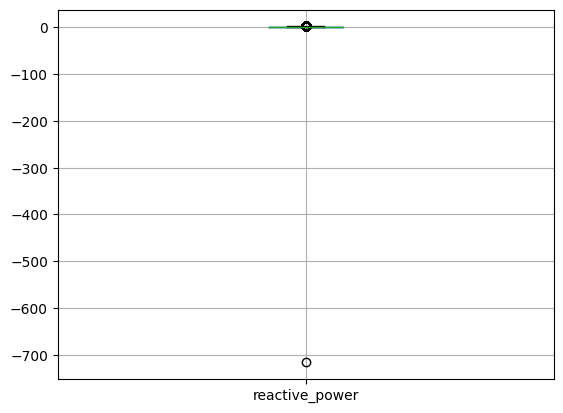

In [53]:
data_arc.boxplot(column=['reactive_power'])  

Действительно, это значение выбивается из оставшихся, и его следует удалить из рассматриваемой выборки.

In [54]:
data_arc = data_arc[data_arc['reactive_power'] >= 0]

<font color='purpel' size=3><b>Комментарий тимлида </b></font>\
<font color='green' size=3> ✔️ Отрицательное значение можно также восстановить, если удаляем, лучше удалить весь ключ(все наблюдение)</font>

Изучим теперь распределения этих параметров. 

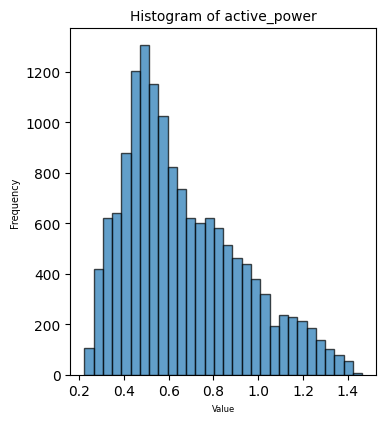

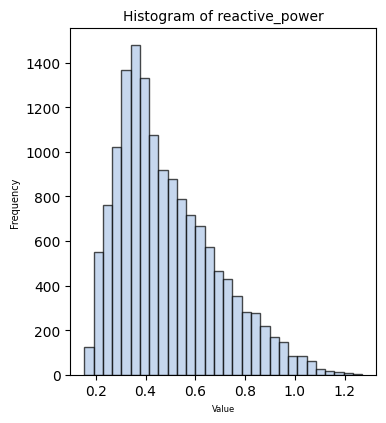

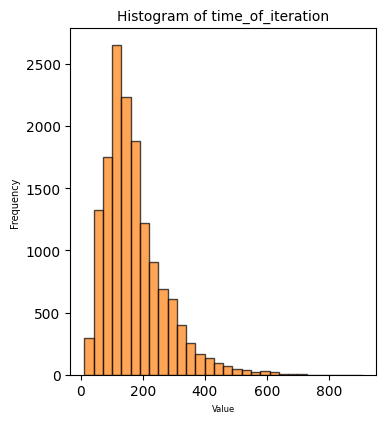

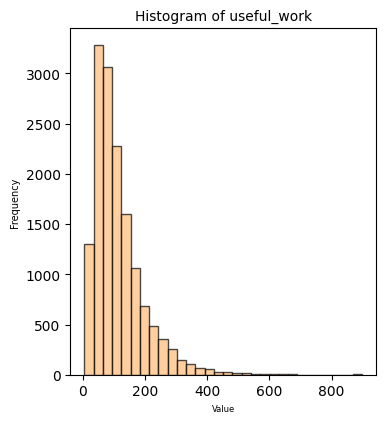

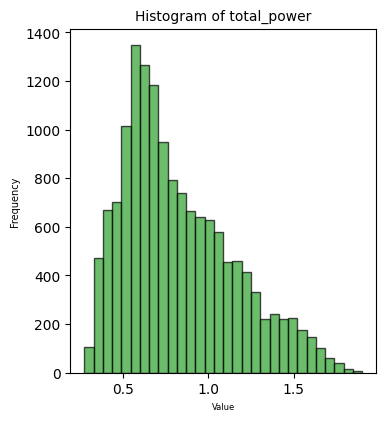

In [55]:
column = pd.Series(data_arc.columns)
column = column.drop(0)
colors = [cm.to_hex(plt.cm.tab20(i)) for i in range(len(column))]
for i, col in enumerate(column):
    fig, axes = plt.subplots(figsize=(4, 4))
    data_arc[col].plot.hist(bins=30, alpha=0.7, color=colors[(i%20)], edgecolor='black')
    plt.tight_layout()
    plt.title(f'Histogram of {col}', fontsize=10)
    plt.xlabel('Value', fontsize=6)
    plt.ylabel('Frequency', fontsize=7)
    plt.show()

In [56]:
column

1         active_power
2       reactive_power
3    time_of_iteration
4          useful_work
5          total_power
dtype: object

**Вывод**: из представленных графиков видно, что распределения всех характеристик для данных об электродах прдеставляют собой унимодальные распределения с четко выраженными пиковыми значениями.

Рассмотрим теперь взаимосвязь между введенными признаками (корреляционную матрицу). 

<AxesSubplot:>

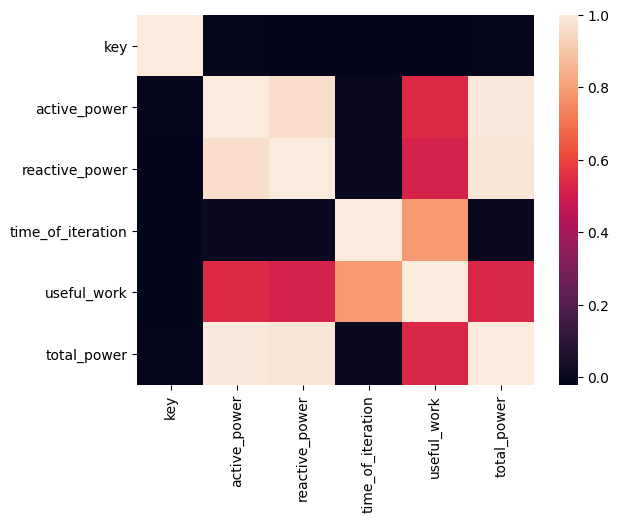

In [57]:
sns.heatmap(data_arc.corr())

**Вывод**: видно, что такие характеристики как активная мощность, реактивная мощность, полная мощность и полезная работа коррелируют между собой, что представляется логичным ввиду их физической взаимосвязи. 

**Сгруппируем** теперь данные по ключу - номеру партии. Такие характеристики, как активная мощность, реактивная мощность, полезная работа, полная мощность будем усреднять по количеству иттераций. Время выполнения же будем рассчитывать суммарное. 

In [58]:
data_arc

,key,active_power,reactive_power,time_of_iteration,useful_work,total_power
0,1,0.305130,0.211253,228.0,69.569640,0.371123
1,1,0.765658,0.477438,185.0,141.646730,0.902319
2,1,0.580313,0.430460,172.0,99.813836,0.722536
3,1,0.518496,0.379979,365.0,189.251040,0.642824
4,1,0.867133,0.643691,148.0,128.335684,1.079934
...,...,...,...,...,...,...
14871,3241,0.439735,0.299579,157.0,69.038395,0.532085
14872,3241,0.646498,0.458240,180.0,116.369640,0.792429
14873,3241,1.039726,0.769302,184.0,191.309584,1.293389
14874,3241,0.530267,0.361543,57.0,30.225219,0.641792


In [59]:
data_arc = data_arc.pivot_table(index='key', values = ['active_power',
                                                       'reactive_power',
                                                       'time_of_iteration',
                                                       'useful_work',
                                                        'total_power'],
                                                          aggfunc={'active_power': "mean", 'reactive_power': "mean", 
                                                                'time_of_iteration': "sum", 
                                                                 'useful_work':"mean",
                                                                  'total_power':"mean"})

In [60]:
data_arc

,active_power,reactive_power,time_of_iteration,total_power,useful_work
key,,,,,
1,0.607346,0.428564,1098.0,0.743747,125.723386
2,0.534852,0.363339,811.0,0.647087,98.820450
3,0.812728,0.587491,655.0,1.003845,116.354925
4,0.676622,0.514248,741.0,0.850010,135.927569
5,0.563238,0.421998,869.0,0.704245,103.045120
...,...,...,...,...,...
3237,0.508374,0.405083,909.0,0.650131,98.630438
3238,0.458274,0.346034,546.0,0.574646,76.463620
3239,0.606001,0.442693,1216.0,0.751810,93.959359


**Вывод**: проведенный исследовательский анализ данных об электродах позволил исключить аномальные значения, ввести дополнительные признаки и сгруппировать данные по номеру партии.

### 2.2 Данные об объеме сыпучих материалов

Исследуем особенности данных об объеме сыпучих материалов. 

In [61]:
data_bulk.describe()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,1624.383509,3.160435,1.779163,47.240332,33.830617,2.633749,21.892298,2.441675,0.015660,0.463407,4.684564,4.345478,203.948226,1.041866,152.706616,115.319271
std,933.337642,11.869164,21.217878,74.239954,56.034505,20.918138,55.492582,31.944063,0.875978,6.154398,20.157323,22.699580,151.419639,14.114252,81.091421,84.488698
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,816.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000
50%,1622.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000
75%,2431.000000,0.000000,0.000000,80.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [62]:
data_bulk


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0
3125,3238,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0
3126,3239,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0
3127,3240,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0


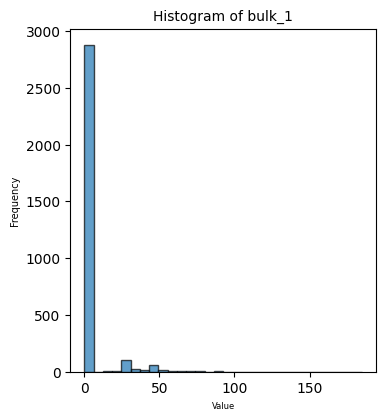

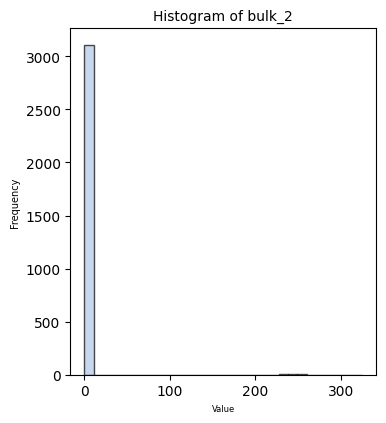

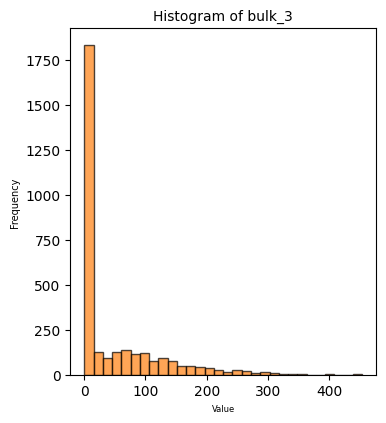

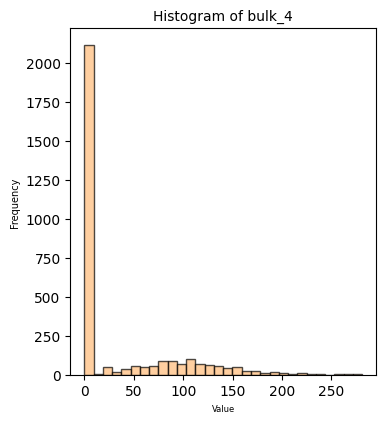

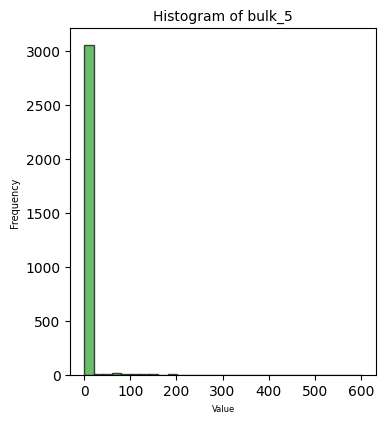

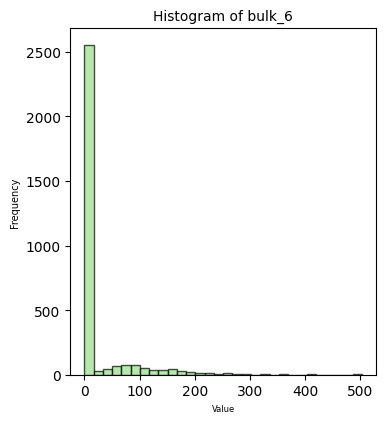

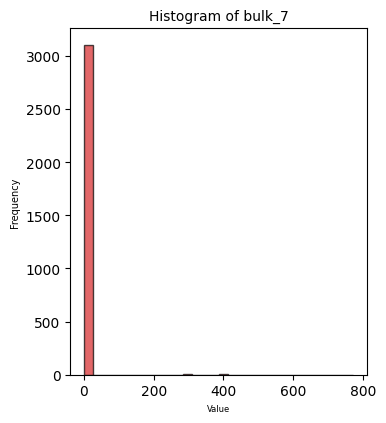

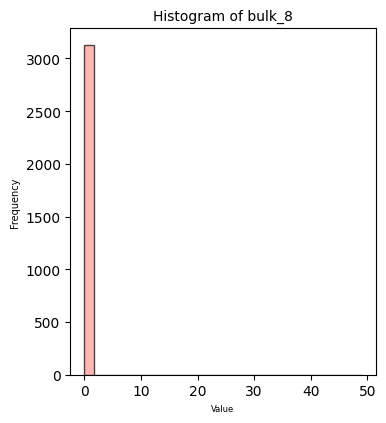

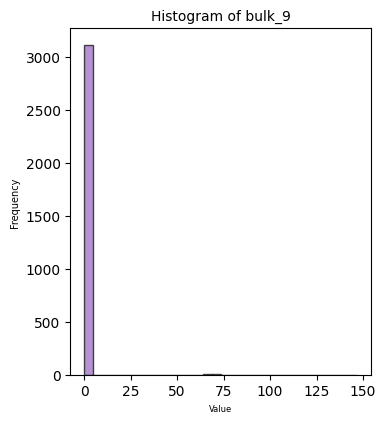

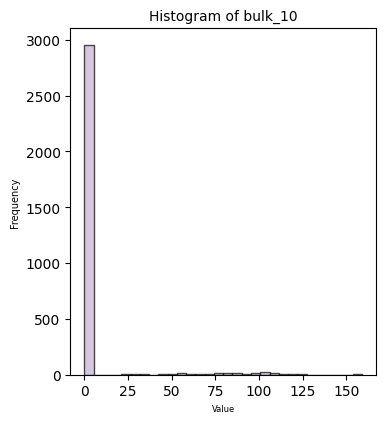

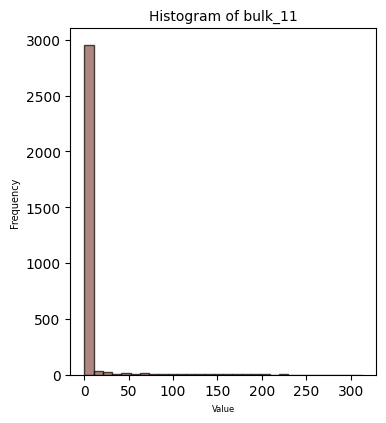

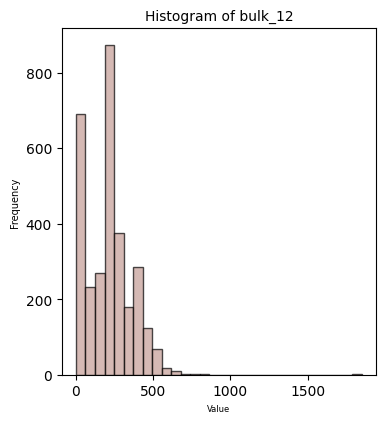

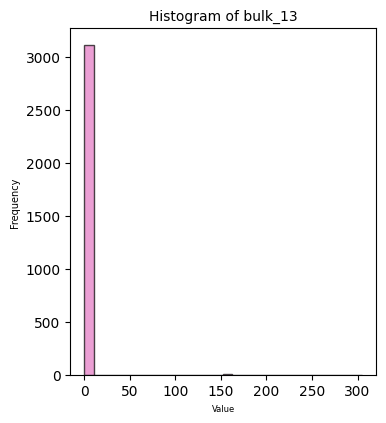

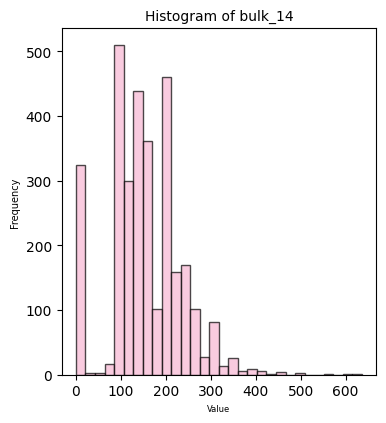

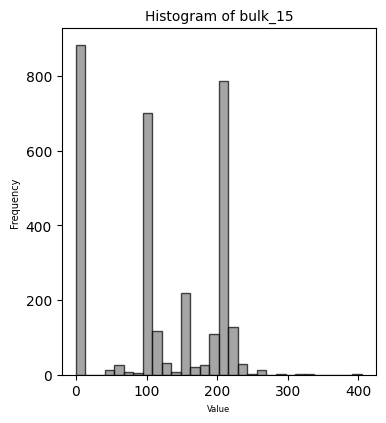

In [63]:
column = pd.Series(data_bulk.columns)
column = column.drop(0)
colors = [cm.to_hex(plt.cm.tab20(i)) for i in range(len(column))]
for i, col in enumerate(column):
    fig, axes = plt.subplots(figsize=(4, 4))
    data_bulk[col].plot.hist(bins=30, alpha=0.7, color=colors[(i%20)], edgecolor='black')
    plt.tight_layout()
    plt.title(f'Histogram of {col}', fontsize=10)
    plt.xlabel('Value', fontsize=6)
    plt.ylabel('Frequency', fontsize=7)
    plt.show()

**Вывод**: с первого по одиннадцатый и тринадцатый супучие материалы выделяются яркими пиковыми значениями, остальные распределения носят многомодальный характер. 

Для каждой партии **введем два дополнительных признака** на основе этих данных - количество разных примененных супычих материалов и суммарный объем всех сыпучих материалов.

In [64]:
data_bulk['number_of_bulks'] = data_bulk.gt(0).sum(axis=1)-1
data_bulk.loc[:,'sum_of_bulks'] = data_bulk.sum(axis=1)-data_bulk['key']-data_bulk['number_of_bulks']
data_bulk

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,number_of_bulks,sum_of_bulks
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,4,553.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,4,582.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,4,544.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,4,595.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,4,584.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0,4,758.0
3125,3238,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0,4,594.0
3126,3239,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0,4,630.0
3127,3240,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0,3,272.0


Проанализируем, как часто используются те или иные материалы, т.е. ненулевые строки соответствующих материалов. 

In [65]:
#Выделим данные по материалам
data_bulk_count = data_bulk[data_bulk.columns[1:16]]
data_bulk_count_sums = []
#Подсчитаем количество ненулевых материалов для каждого из них 
for colum in data_bulk_count.columns:
    count = data_bulk_count[colum] > 0 
    data_bulk_count_sums.append(count.sum())
#Выделим для этого отдельный датафрейм
df = pd.DataFrame(data_bulk_count_sums, index = data_bulk_count.columns)
df

,0
bulk_1,252
bulk_2,22
bulk_3,1298
bulk_4,1014
bulk_5,77
bulk_6,576
bulk_7,25
bulk_8,1
bulk_9,19
bulk_10,176


Text(0, 0.5, 'Частота употребления')

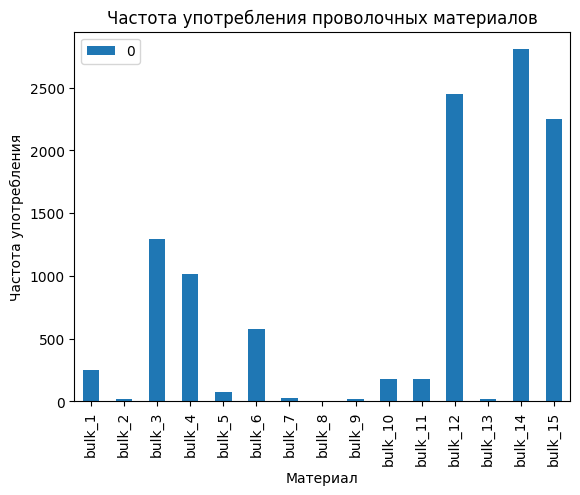

In [66]:
#Визуализируем данные
df.plot(kind = 'bar')
plt.title('Частота употребления проволочных материалов')
plt.xlabel('Материал')
plt.ylabel('Частота употребления')

**Вывод**: видно, что  8 материал используется только один раз. Его можно удалить из выборки

In [67]:
data_bulk = data_bulk.drop(['bulk_8'], axis = 1)

**Вывод**: для данных по объемам сыпучих материалов изучены представленные статистические характеристики, построены соответсвующие распределения. Для дальнейшего применения введены такие дополнительные признаки, как количество ненулевых материалов и общий объем материалов. Также были удалены признаки (материалы), которые встречаются небольшое количество раз. 

### 2.3 Данные по времени подачи сыпучих материалов

Данные о времени подачи не несут высокой информационной значимости для описываемой модели. Поэтому в конечную таблицу мы их не включим. 

### 2.4 Данные о продувке сплава газом 

In [68]:
data_gas.describe()

,key,gas_1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Text(0, 0.5, 'Частота')

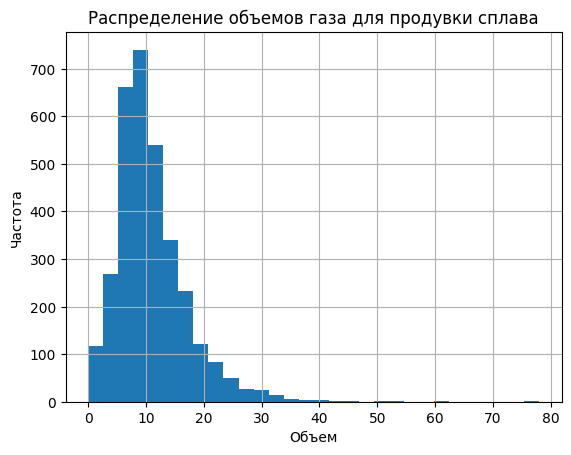

In [69]:
data_gas['gas_1'].hist(bins=30)
plt.title('Распределение объемов газа для продувки сплава')
plt.xlabel('Объем')
plt.ylabel('Частота')

<AxesSubplot:>

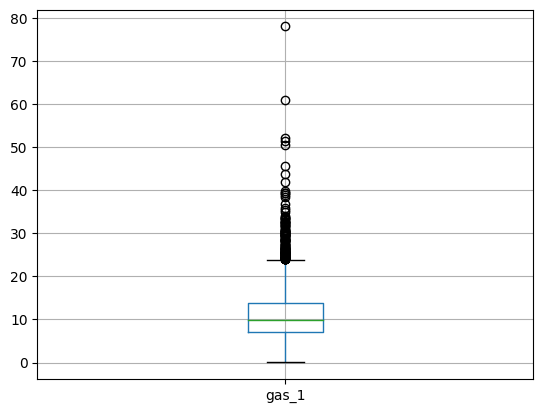

In [70]:
data_gas.boxplot(column=['gas_1'])  

**Вывод**: распределение газа по объему напоминает по виду распределение Бернулли, на графике "ящик с усами" видны единичные выбросы, но для того, чтобы принимать их за аномальные значения нет оснований. 

### 2.5 Данные о температуре 

Данные по температуре являются с одной стороны целевыми параметрами (это относится к конечной температуре, с другой стороны входящая температура может быть использована как один из признаков. Известно также, что температура сплава не может быть ниже 1500 градусов (он в таком случае кристаллизуется), поэтому такие данные необходимо удалить из датафрейма. 

In [71]:
data_temp.tail(20)

,key,measuring_time,temperature
18072,3239,2019-09-06 14:22:49,NaN
18073,3239,2019-09-06 14:28:54,NaN
18074,3239,2019-09-06 14:33:34,NaN
18075,3239,2019-09-06 14:42:48,NaN
18076,3239,2019-09-06 14:56:58,NaN
18077,3239,2019-09-06 14:59:25,NaN
18078,3239,2019-09-06 15:03:35,NaN
18079,3239,2019-09-06 15:09:55,NaN
18080,3240,2019-09-06 15:25:21,1617.0
18081,3240,2019-09-06 15:30:52,NaN


In [72]:
#Удаление пропущенных значений
keys = list(data_temp[data_temp['temperature'].isna()]['key'])
data_temp = data_temp.query("key not in @keys")
data_temp

,key,measuring_time,temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
13921,2499,2019-08-10 13:33:21,1569.0
13922,2499,2019-08-10 13:41:34,1604.0
13923,2499,2019-08-10 13:46:28,1593.0
13924,2499,2019-08-10 13:54:56,1588.0


In [73]:
#Выделим значения и партии, в которых температура принимает некорректные значения
keys = list(data_temp[data_temp['temperature'] < 1500]['key'])
data_temp = data_temp.query("key not in @keys")


Выделим теперь признаки - входящее и конечное значение температуры. 

In [74]:
data_temp.head(20)

,key,measuring_time,temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


In [75]:
def input_(temp):
    return temp.iloc[0]
def output_(temp):
    return temp.iloc[-1]

data_temp = pd.pivot_table(data_temp,
               index=['key'],
               values=['temperature'],
               aggfunc = [input_, output_])

In [76]:
data_temp.columns = data_temp.columns.map(''.join)

**Вывод**: таким образом, исходные данные о температуре проанализированы, убраны нулевые значения, убраны значения не соответсвующие условиям жидкой стали, данные сгруппированы по партиям и выделены в качестве признаков входная и выходная температуры.

### 2.6 Данные об объеме проволочных материалов

В этом случае поступим аналогично данным о сыпучих материалах

In [77]:
data_wire.describe()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000
mean,1623.426485,100.044411,17.712733,3.874524,0.261019,0.004911,1.137695,0.035842,0.330697,0.321492
std,932.996726,42.841120,33.517734,30.310417,4.293865,0.272615,8.958111,0.774190,4.392677,3.806904
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,823.000000,70.281120,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1619.000000,100.114563,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2434.000000,125.798405,23.162880,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132000,180.454575,32.847674,102.762401,90.053604


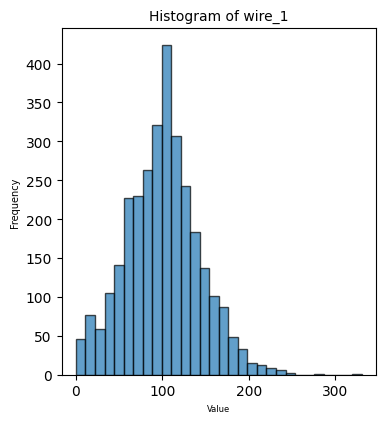

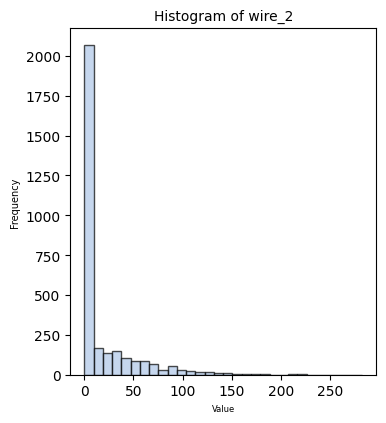

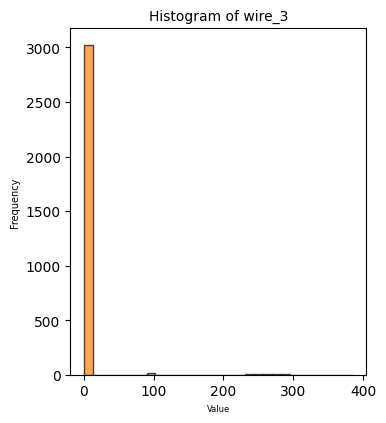

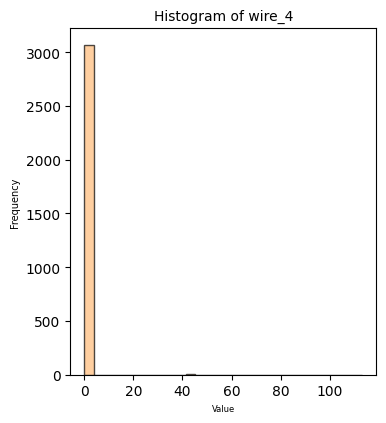

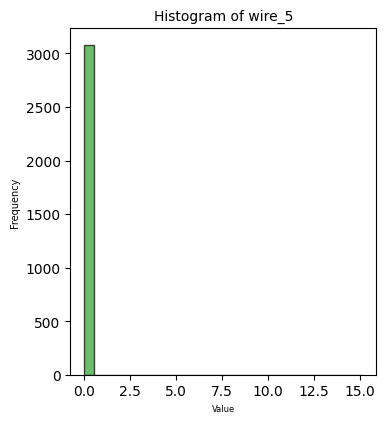

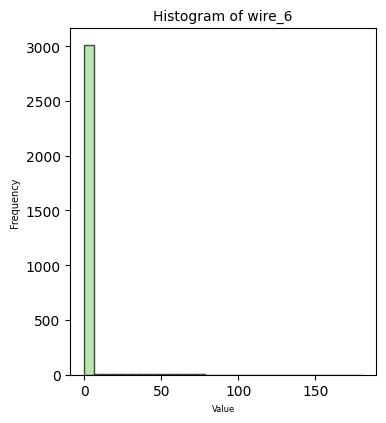

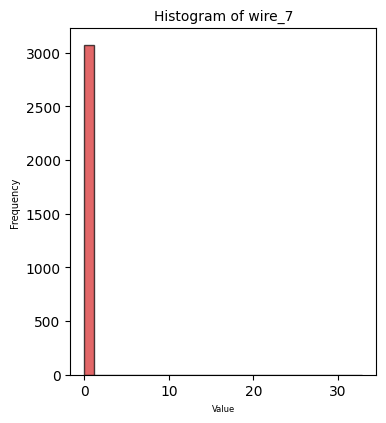

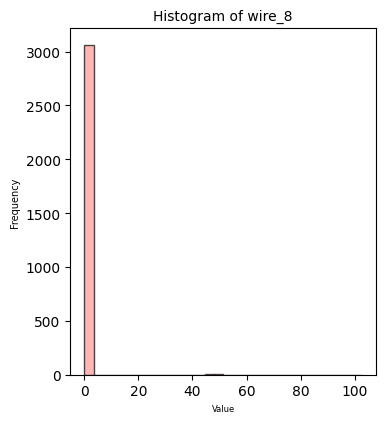

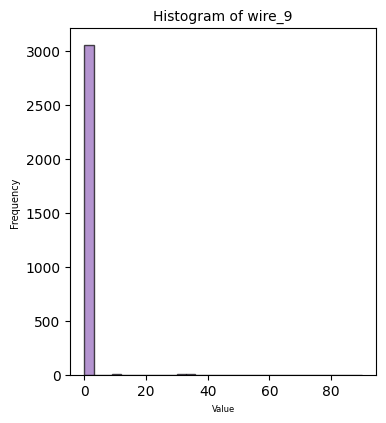

In [78]:
column = pd.Series(data_wire.columns)
column = column.drop(0)
colors = [cm.to_hex(plt.cm.tab20(i)) for i in range(len(column))]
for i, col in enumerate(column):
    fig, axes = plt.subplots(figsize=(4, 4))
    data_wire[col].plot.hist(bins=30, alpha=0.7, color=colors[(i%20)], edgecolor='black')
    plt.tight_layout()
    plt.title(f'Histogram of {col}', fontsize=10)
    plt.xlabel('Value', fontsize=6)
    plt.ylabel('Frequency', fontsize=7)
    plt.show()

Введем два признака - количество используемых материалов и суммарный объем. 

In [79]:
data_wire['number_of_wires'] = data_wire.gt(0).sum(axis=1)-1
data_wire.loc[:,'sum_of_wires'] = data_wire.sum(axis=1)-data_wire['key']-data_wire['number_of_wires']
data_wire

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,number_of_wires,sum_of_wires
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,60.059998
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,96.052315
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,91.160157
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,89.063515
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,98.352796
...,...,...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,38.088959
3077,3238,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,56.128799
3078,3239,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,143.357761
3079,3240,34.070400,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,34.070400


Отметим, что большое количество данных по этим материалам - нулевые, что может быть избыточным для нашей модели. Посмотрим, какие материалы использовались чаще и больше остальных.

In [80]:
#Выделим данные по материалам
data_wire_count = data_wire[data_wire.columns[1:10]]
data_wire_count_sums = []
#Подсчитаем количество ненулевых материалов для каждого из них 
for colum in data_wire_count.columns:
    count = data_wire_count[colum] > 0 
    data_wire_count_sums.append(count.sum())
#Выделим для этого отдельный датафрейм
df = pd.DataFrame(data_wire_count_sums, index = data_wire_count.columns)
df

,0
wire_1,3055
wire_2,1079
wire_3,63
wire_4,14
wire_5,1
wire_6,73
wire_7,11
wire_8,19
wire_9,29


Text(0, 0.5, 'Частота употребления')

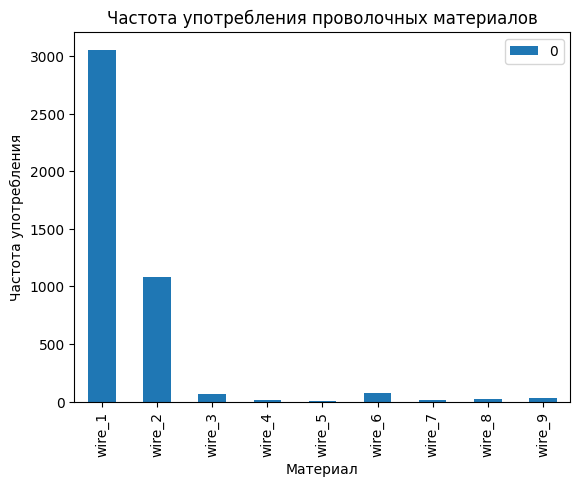

In [81]:
#Визуализируем данные
df.plot(kind = 'bar')
plt.title('Частота употребления проволочных материалов')
plt.xlabel('Материал')
plt.ylabel('Частота употребления')

**Вывод**:Видно, что 5 материал встречается всего один раз, его можно убрать.

In [82]:
data_wire = data_wire.drop(['wire_5', ], axis = 1)

**Вывод**: для данных по проволочным материалам введены два дополнительных признака - общее количество добавленных материалов и суммарный объем. Убраны материалы, которые встречаются незначительное количество раз. 

### 2.7 Данные о времени подачи проволочных материалов

Аналогично сыпучим материалам, данные о времени для итоговой модели использовать не будем. 

**Вывод**:

## 3. Объединение данных

Объединим подготовленные данные в единный датафрейм. 

In [83]:
data_full = data_arc.join(data_bulk.set_index('key'), on='key', how='inner')
data_full = data_full.join(data_wire.set_index('key'), on='key', how='inner')
data_full = data_full.join(data_gas.set_index('key'), on='key', how = 'inner')
data_full = data_full.join(data_temp, on='key', how = 'inner')
data_full

,active_power,reactive_power,time_of_iteration,total_power,useful_work,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,...,wire_4,wire_6,wire_7,wire_8,wire_9,number_of_wires,sum_of_wires,gas_1,input_temperature,output_temperature
key,,,,,,,,,,,,,,,,,,,,,
1,0.607346,0.428564,1098.0,0.743747,125.723386,0.0,0.0,0.0,43.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,60.059998,29.749986,1571.0,1613.0
2,0.534852,0.363339,811.0,0.647087,98.820450,0.0,0.0,0.0,73.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,96.052315,12.555561,1581.0,1602.0
3,0.812728,0.587491,655.0,1.003845,116.354925,0.0,0.0,0.0,34.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,91.160157,28.554793,1596.0,1599.0
4,0.676622,0.514248,741.0,0.850010,135.927569,0.0,0.0,0.0,81.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,89.063515,18.841219,1601.0,1625.0
5,0.563238,0.421998,869.0,0.704245,103.045120,0.0,0.0,0.0,78.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2,98.352796,5.413692,1576.0,1602.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0.792033,0.552734,723.0,0.967180,142.884829,0.0,0.0,21.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,89.150879,7.125735,1570.0,1591.0
2496,0.695820,0.478672,940.0,0.845053,112.537078,0.0,0.0,0.0,63.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,114.179527,9.412616,1554.0,1591.0
2497,1.201746,0.817364,569.0,1.453639,226.775558,0.0,0.0,0.0,85.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2,103.134723,6.271699,1571.0,1589.0


**Вывод**: для дальнейшего моделирования были объединены в единый датасет информация по электродам, по сыпучим и проволочным материалам, по газу и по измеряемой температуре. 

## 4. Исследовательский анализ и предобработка данных объединенного датафрейма 

Проведем общий исследовательский анализ полученного датафрейма. Еще раз рассмотрим распределения и взаимосвязи всех полученных признаков. 

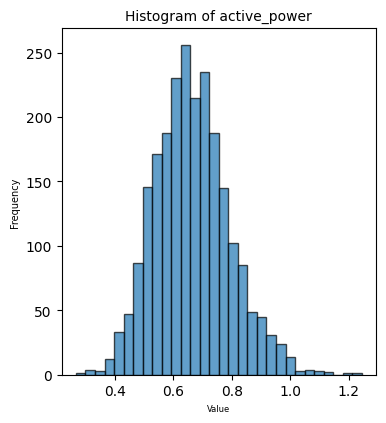

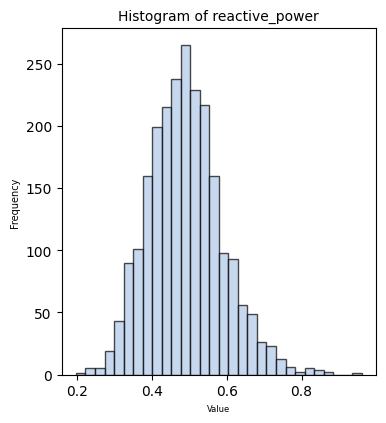

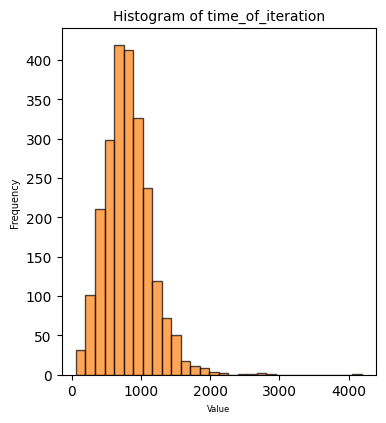

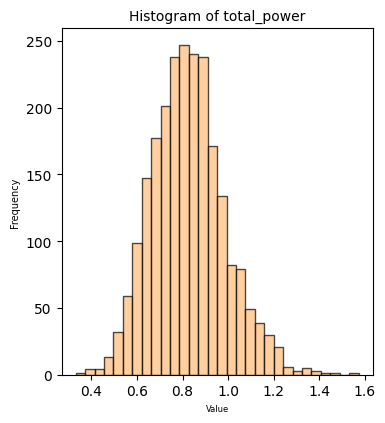

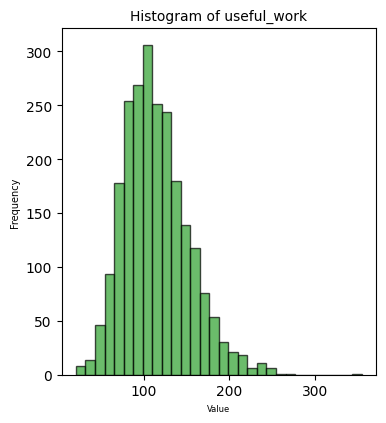

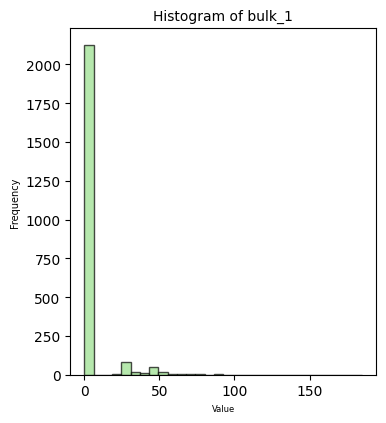

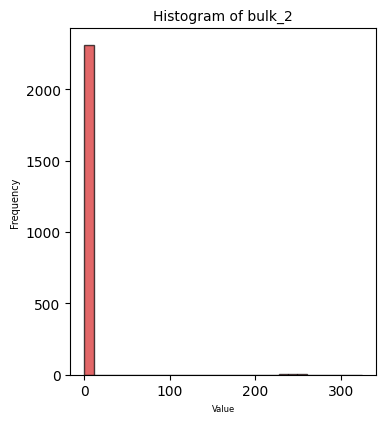

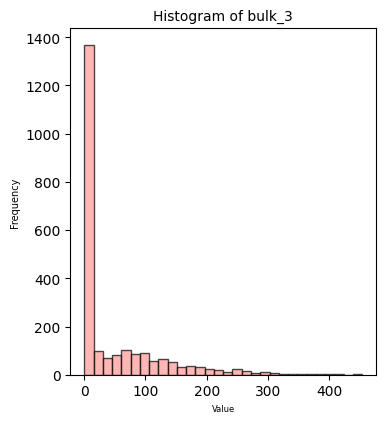

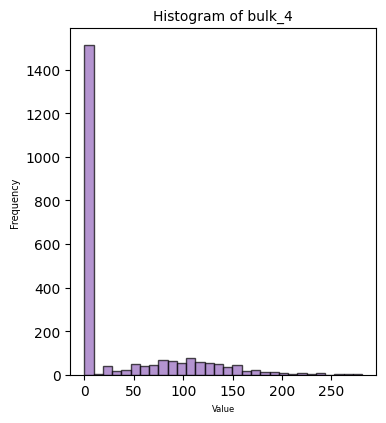

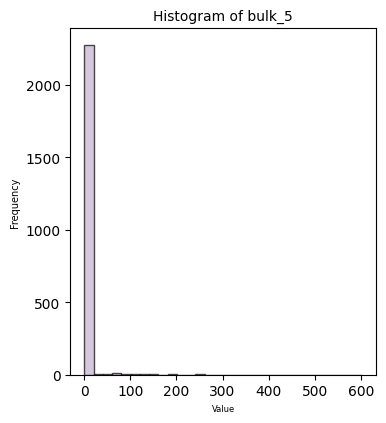

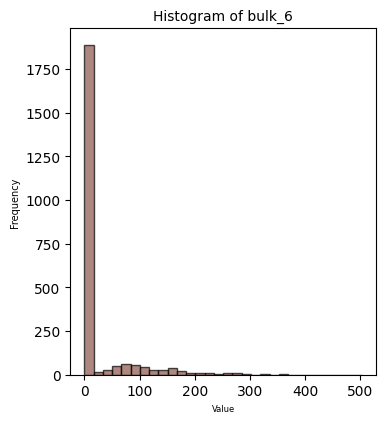

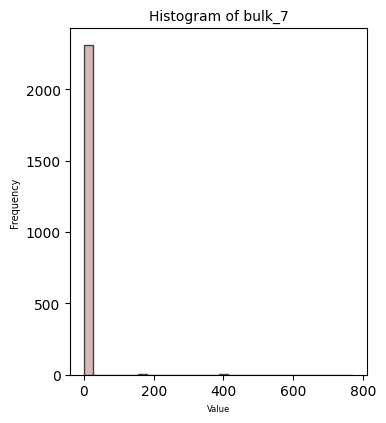

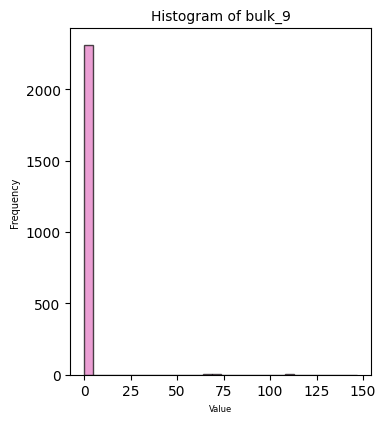

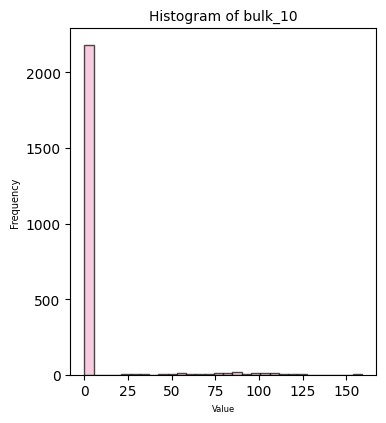

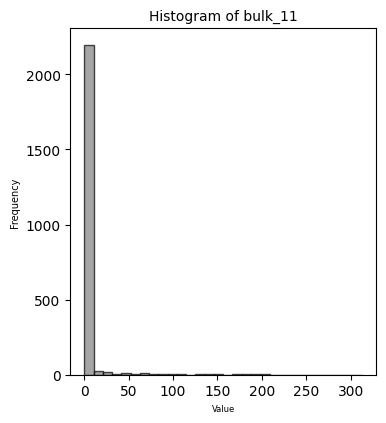

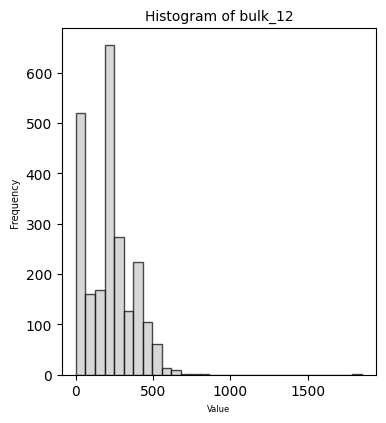

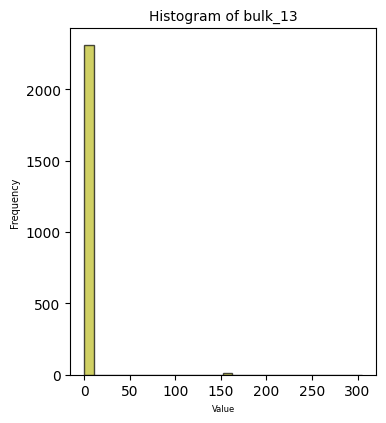

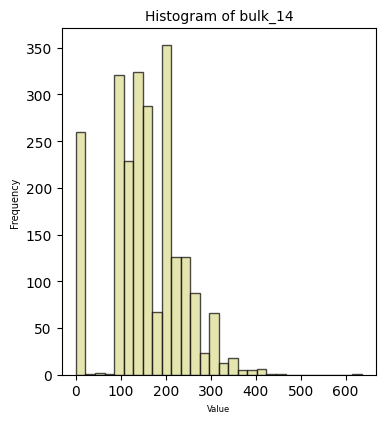

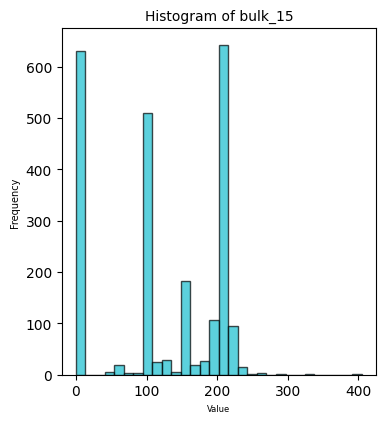

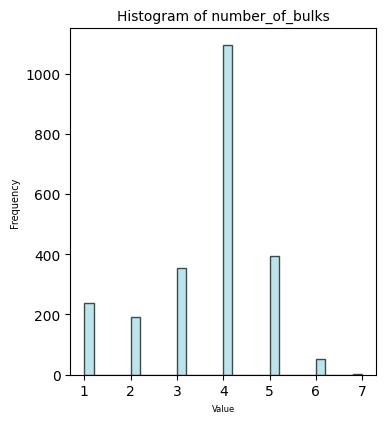

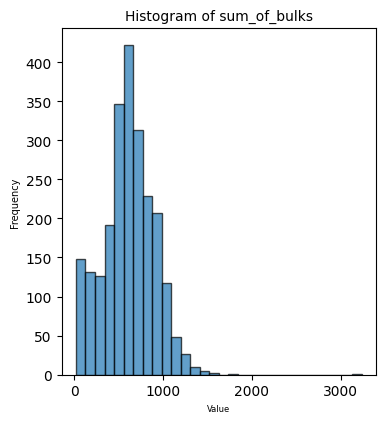

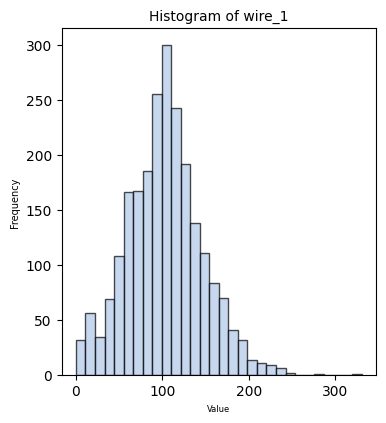

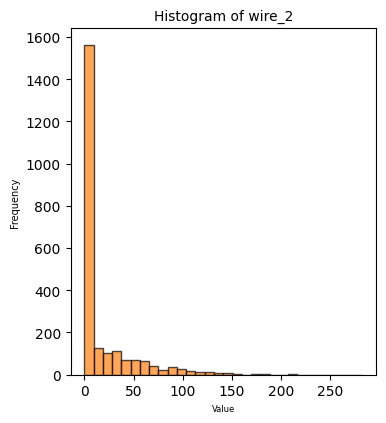

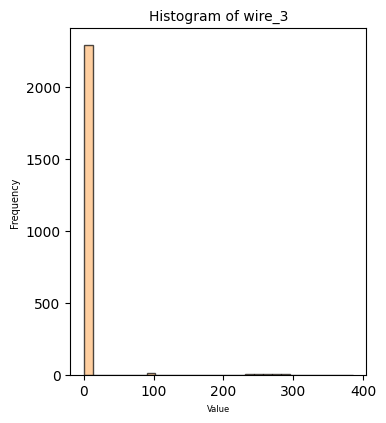

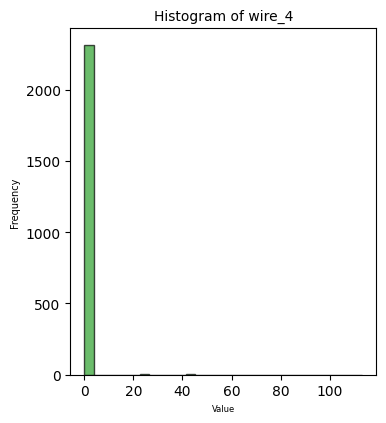

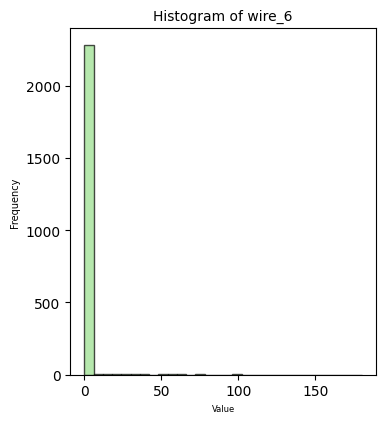

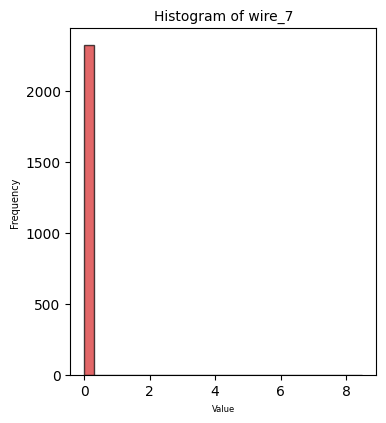

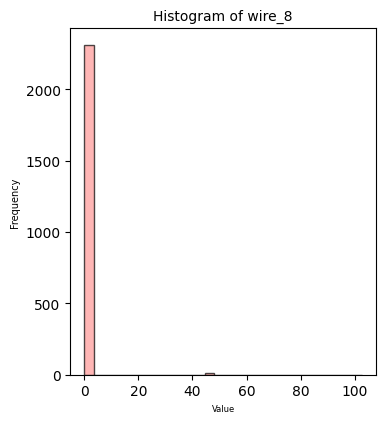

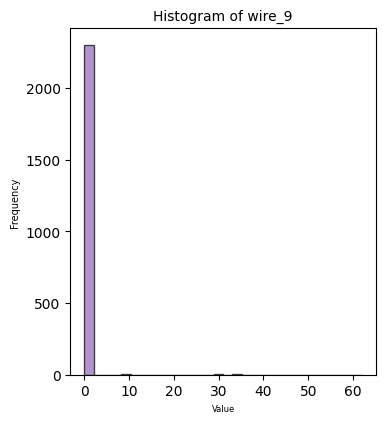

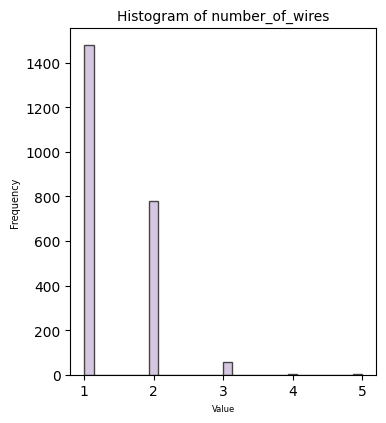

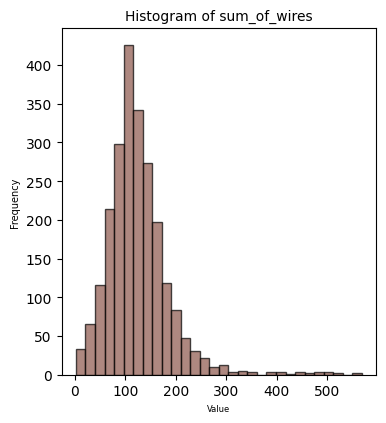

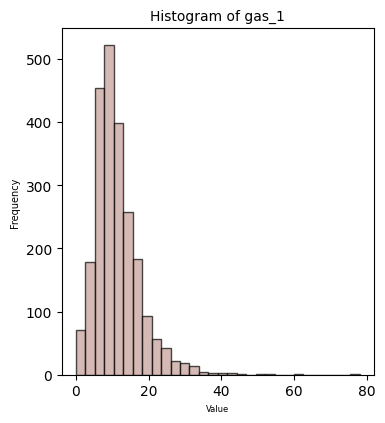

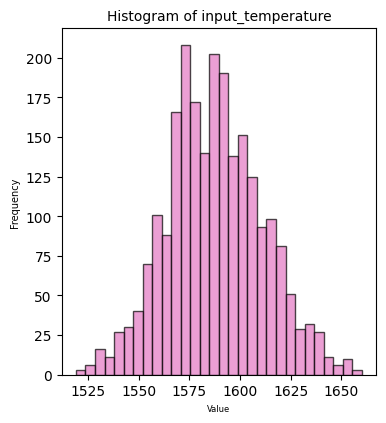

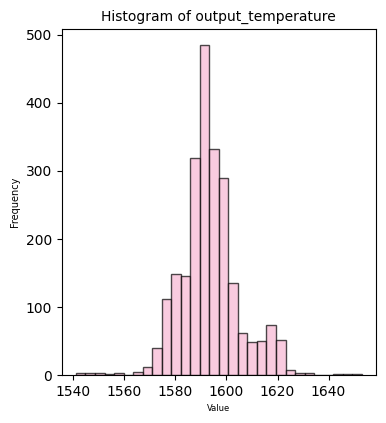

In [84]:
column = pd.Series(data_full.columns)
colors = [cm.to_hex(plt.cm.tab20(i)) for i in range(len(column))]
for i, col in enumerate(column):
    fig, axes = plt.subplots(figsize=(4, 4))
    data_full[col].plot.hist(bins=30, alpha=0.7, color=colors[(i%20)], edgecolor='black')
    plt.tight_layout()
    plt.title(f'Histogram of {col}', fontsize=10)
    plt.xlabel('Value', fontsize=6)
    plt.ylabel('Frequency', fontsize=7)
    plt.show()

<AxesSubplot:>

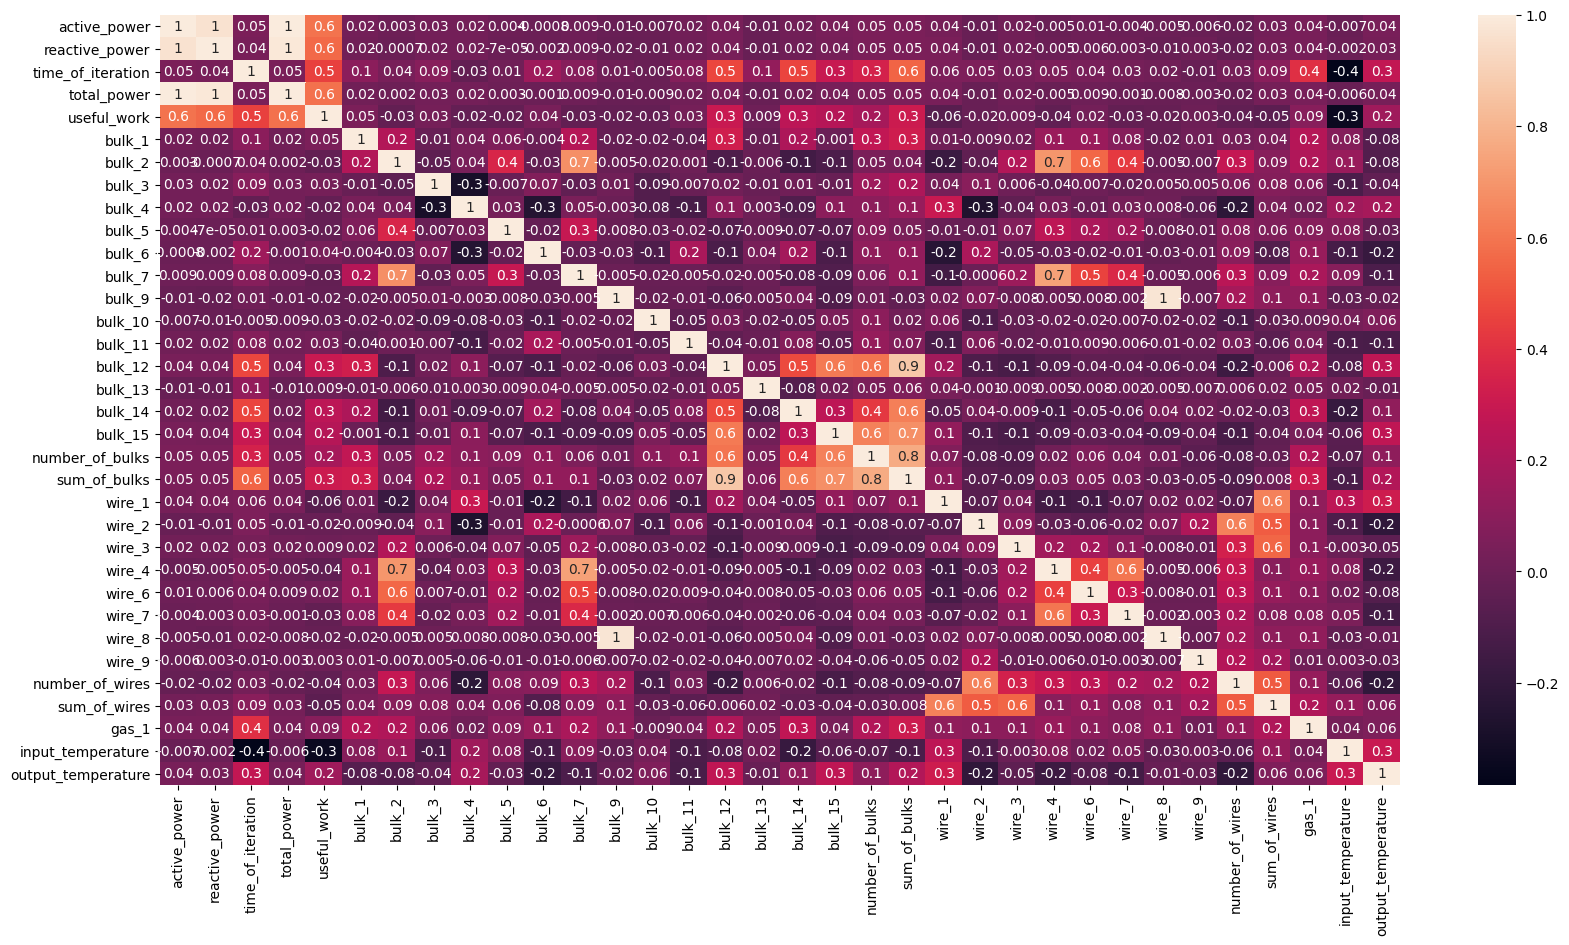

In [85]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(data_full.corr(), annot = True,  fmt='.1g')

**Вывод**: исходные данные объединены в общий датафрейм. Проанализировано распределение признаков - оно совпадает с расмотренными ранее, изучена корреляция признаков. Большая часть данных не коррелирует между собой, что говорит о правильности их введения. 

## 5. Подготовка данных

Проведем подготовку наших данных к обучению. 

In [86]:
features = data_full.drop(['output_temperature'],axis=1)
target = data_full['output_temperature']

In [87]:
features.shape

(2325, 33)

Разделим нашу выборку на обучающую и тестовую в соотношении 1:3. 

In [88]:
train_features, test_features, train_target, test_target = train_test_split(features, target, test_size=0.25, random_state=121223)

In [89]:
#Проверим получившееся соотношение
train_features.shape[0]/test_features.shape[0]

2.9948453608247423

In [90]:
train_features

,active_power,reactive_power,time_of_iteration,total_power,useful_work,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,...,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,number_of_wires,sum_of_wires,gas_1,input_temperature
key,,,,,,,,,,,,,,,,,,,,,
2470,0.579115,0.401986,478.0,0.705094,88.219698,0.0,0.0,51.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.3568,3,241.500476,9.812350,1627.0
1776,0.640664,0.446015,1036.0,0.780682,166.805222,0.0,0.0,106.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,1,74.973606,10.979479,1586.0
360,0.662813,0.499950,1315.0,0.831188,153.912811,0.0,0.0,0.0,144.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,1,84.239998,14.995135,1548.0
522,0.544575,0.358654,690.0,0.652172,99.512531,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,2,155.243917,20.655266,1571.0
2250,0.367136,0.262338,272.0,0.451278,45.583259,0.0,0.0,0.0,147.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,1,115.053116,35.769306,1640.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2381,0.560800,0.436929,900.0,0.711895,104.841387,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,2,100.293444,9.694249,1564.0
912,0.757528,0.579501,1021.0,0.954255,121.028502,0.0,0.0,280.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,1,75.301201,15.770561,1586.0
537,0.667078,0.463516,1257.0,0.813074,159.322520,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,1,100.011597,8.134472,1590.0


Проведем масштабирование данных. 

In [91]:
numeric= train_features.columns
#Проведем масштабирование данных
scaler = StandardScaler()
pd.options.mode.chained_assignment = None
scaler.fit(features[numeric]) 
train_features[numeric] = scaler.transform(train_features[numeric])
test_features[numeric] = scaler.transform(test_features[numeric])
train_features.head()

,active_power,reactive_power,time_of_iteration,total_power,useful_work,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,...,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,number_of_wires,sum_of_wires,gas_1,input_temperature
key,,,,,,,,,,,,,,,,,,,,,
2470,-0.662837,-0.887321,-0.968233,-0.751790,-0.690659,-0.276468,-0.074627,0.049237,-0.636431,-0.117982,...,-0.115895,-0.064501,-0.112717,-0.030954,-0.070785,3.191642,2.840287,1.826848,-0.245000,1.678158
1776,-0.183353,-0.437963,0.669018,-0.280378,1.365267,-0.276468,-0.074627,0.780503,-0.636431,-0.117982,...,-0.115895,-0.064501,-0.112717,-0.030954,-0.070785,-0.091842,-0.703404,-0.788547,-0.062472,-0.057802
360,-0.010802,0.112489,1.487644,0.034614,1.027980,-0.276468,-0.074627,-0.628845,1.818487,-0.117982,...,-0.115895,-0.064501,-0.112717,-0.030954,-0.070785,-0.091842,-0.703404,-0.643013,0.565538,-1.666740
522,-0.931912,-1.329566,-0.346195,-1.081846,-0.395220,-0.276468,-0.074627,-0.628845,-0.636431,-0.117982,...,-0.115895,-0.064501,-0.112717,-0.030954,-0.070785,-0.091842,1.068442,0.472142,1.450727,-0.692909
2250,-2.314216,-2.312560,-1.572666,-2.334760,-1.806098,-0.276468,-0.074627,-0.628845,1.869631,-0.117982,...,-0.115895,-0.064501,-0.112717,-0.030954,-0.070785,-0.091842,-0.703404,-0.159076,3.814417,2.228584


**Вывод**: из исходных данных выделены целевые признаки и обычные,  все признаки таким образом масштабированы, и в итоге они разделены на тестовую и тренировочную выборки. Проведено масштабирование данных. 

## 6. Обучение моделей машинного обучения

### 6.1 Градиентный бустинг


Обучим и исследуем модель CatBoostRegressor. Модель градиентного бустинга в данном случае хорошо подходит, так как работает с неоднородными данными.

In [92]:
#Создадим функцию оценки по mean_absolute_error
def mae(prediction, target):
    return (mean_absolute_error(target,prediction)).round(2)
scorer = make_scorer(mae, greater_is_better=False)

In [93]:
model = CatBoostRegressor(verbose = 0)
grid = {
         'n_estimators': [800, 900, 1000],
         'learning_rate': [0.03, 0.1],
         'depth': [4, 6, 10]
        }
gsearch = GridSearchCV(estimator=model, 
                       cv=5, 
                       param_grid=grid,  
                       scoring = scorer)
gsearch.fit(train_features, train_target)

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x000002697912AAC0>,
             param_grid={'depth': [4, 6, 10], 'learning_rate': [0.03, 0.1],
                         'n_estimators': [800, 900, 1000]},
             scoring=make_scorer(mae, greater_is_better=False))

In [94]:
gsearch.best_params_

{'depth': 6, 'learning_rate': 0.03, 'n_estimators': 800}

In [95]:
gsearch.best_score_

-6.2219999999999995

Исследуем время обучения нашей модели.

In [96]:
%%time
start = time.time()
model_boost = CatBoostRegressor(random_state=111223,learning_rate=0.03, n_estimators=800, depth = 6)
model_boost.fit(train_features, train_target)
end = time.time()
t_boost=round(end-start,2)

0:	learn: 11.1149753	total: 3.66ms	remaining: 2.92s
1:	learn: 11.0318391	total: 9ms	remaining: 3.59s
2:	learn: 10.9450963	total: 13.3ms	remaining: 3.53s
3:	learn: 10.8767984	total: 16.5ms	remaining: 3.29s
4:	learn: 10.8018378	total: 19.6ms	remaining: 3.12s
5:	learn: 10.7250311	total: 24.8ms	remaining: 3.29s
6:	learn: 10.6660746	total: 29ms	remaining: 3.29s
7:	learn: 10.5898396	total: 32.1ms	remaining: 3.18s
8:	learn: 10.5189975	total: 35.3ms	remaining: 3.1s
9:	learn: 10.4628297	total: 41.6ms	remaining: 3.29s
10:	learn: 10.3951697	total: 45.4ms	remaining: 3.26s
11:	learn: 10.3365527	total: 48.9ms	remaining: 3.21s
12:	learn: 10.2744644	total: 52.9ms	remaining: 3.2s
13:	learn: 10.2202327	total: 58.1ms	remaining: 3.26s
14:	learn: 10.1609546	total: 61.9ms	remaining: 3.24s
15:	learn: 10.1093756	total: 64.9ms	remaining: 3.18s
16:	learn: 10.0587176	total: 68.9ms	remaining: 3.17s
17:	learn: 10.0068883	total: 74.3ms	remaining: 3.23s
18:	learn: 9.9540264	total: 77.9ms	remaining: 3.2s
19:	learn: 9

162:	learn: 7.6185905	total: 791ms	remaining: 3.09s
163:	learn: 7.6129145	total: 795ms	remaining: 3.08s
164:	learn: 7.6072183	total: 800ms	remaining: 3.08s
165:	learn: 7.5964314	total: 804ms	remaining: 3.07s
166:	learn: 7.5907260	total: 807ms	remaining: 3.06s
167:	learn: 7.5850160	total: 810ms	remaining: 3.05s
168:	learn: 7.5785314	total: 815ms	remaining: 3.04s
169:	learn: 7.5719148	total: 821ms	remaining: 3.04s
170:	learn: 7.5642960	total: 824ms	remaining: 3.03s
171:	learn: 7.5599856	total: 828ms	remaining: 3.02s
172:	learn: 7.5471095	total: 833ms	remaining: 3.02s
173:	learn: 7.5413146	total: 837ms	remaining: 3.01s
174:	learn: 7.5368508	total: 840ms	remaining: 3s
175:	learn: 7.5323208	total: 843ms	remaining: 2.99s
176:	learn: 7.5290240	total: 849ms	remaining: 2.99s
177:	learn: 7.5238470	total: 853ms	remaining: 2.98s
178:	learn: 7.5173737	total: 856ms	remaining: 2.97s
179:	learn: 7.5084888	total: 859ms	remaining: 2.96s
180:	learn: 7.4991012	total: 864ms	remaining: 2.96s
181:	learn: 7.4

325:	learn: 6.7314947	total: 1.59s	remaining: 2.31s
326:	learn: 6.7283280	total: 1.59s	remaining: 2.3s
327:	learn: 6.7250242	total: 1.6s	remaining: 2.3s
328:	learn: 6.7235932	total: 1.6s	remaining: 2.29s
329:	learn: 6.7166196	total: 1.61s	remaining: 2.29s
330:	learn: 6.7102033	total: 1.61s	remaining: 2.29s
331:	learn: 6.7031856	total: 1.62s	remaining: 2.28s
332:	learn: 6.7019197	total: 1.62s	remaining: 2.28s
333:	learn: 6.6925046	total: 1.63s	remaining: 2.27s
334:	learn: 6.6900676	total: 1.63s	remaining: 2.27s
335:	learn: 6.6859992	total: 1.64s	remaining: 2.26s
336:	learn: 6.6811376	total: 1.64s	remaining: 2.26s
337:	learn: 6.6750476	total: 1.65s	remaining: 2.25s
338:	learn: 6.6702844	total: 1.65s	remaining: 2.25s
339:	learn: 6.6644150	total: 1.66s	remaining: 2.25s
340:	learn: 6.6597026	total: 1.67s	remaining: 2.24s
341:	learn: 6.6568309	total: 1.67s	remaining: 2.23s
342:	learn: 6.6523494	total: 1.68s	remaining: 2.23s
343:	learn: 6.6474336	total: 1.68s	remaining: 2.23s
344:	learn: 6.64

499:	learn: 5.9705416	total: 2.37s	remaining: 1.42s
500:	learn: 5.9686639	total: 2.38s	remaining: 1.42s
501:	learn: 5.9660103	total: 2.38s	remaining: 1.41s
502:	learn: 5.9606729	total: 2.38s	remaining: 1.41s
503:	learn: 5.9585692	total: 2.39s	remaining: 1.4s
504:	learn: 5.9564560	total: 2.39s	remaining: 1.4s
505:	learn: 5.9547701	total: 2.4s	remaining: 1.39s
506:	learn: 5.9482524	total: 2.4s	remaining: 1.39s
507:	learn: 5.9455516	total: 2.41s	remaining: 1.38s
508:	learn: 5.9414997	total: 2.41s	remaining: 1.38s
509:	learn: 5.9372237	total: 2.42s	remaining: 1.37s
510:	learn: 5.9308468	total: 2.42s	remaining: 1.37s
511:	learn: 5.9265384	total: 2.42s	remaining: 1.36s
512:	learn: 5.9255718	total: 2.43s	remaining: 1.36s
513:	learn: 5.9199903	total: 2.43s	remaining: 1.35s
514:	learn: 5.9158316	total: 2.44s	remaining: 1.35s
515:	learn: 5.9115384	total: 2.44s	remaining: 1.34s
516:	learn: 5.9066183	total: 2.44s	remaining: 1.34s
517:	learn: 5.9006289	total: 2.45s	remaining: 1.33s
518:	learn: 5.89

660:	learn: 5.4710525	total: 3.15s	remaining: 664ms
661:	learn: 5.4698603	total: 3.16s	remaining: 659ms
662:	learn: 5.4691531	total: 3.16s	remaining: 653ms
663:	learn: 5.4671588	total: 3.17s	remaining: 649ms
664:	learn: 5.4662905	total: 3.17s	remaining: 644ms
665:	learn: 5.4637465	total: 3.17s	remaining: 639ms
666:	learn: 5.4606589	total: 3.18s	remaining: 634ms
667:	learn: 5.4575222	total: 3.18s	remaining: 629ms
668:	learn: 5.4527968	total: 3.19s	remaining: 624ms
669:	learn: 5.4492363	total: 3.19s	remaining: 619ms
670:	learn: 5.4469163	total: 3.19s	remaining: 614ms
671:	learn: 5.4449423	total: 3.2s	remaining: 609ms
672:	learn: 5.4447387	total: 3.2s	remaining: 604ms
673:	learn: 5.4445500	total: 3.21s	remaining: 599ms
674:	learn: 5.4425756	total: 3.21s	remaining: 594ms
675:	learn: 5.4381515	total: 3.21s	remaining: 589ms
676:	learn: 5.4356218	total: 3.22s	remaining: 584ms
677:	learn: 5.4329140	total: 3.22s	remaining: 580ms
678:	learn: 5.4318370	total: 3.22s	remaining: 574ms
679:	learn: 5.

Исследуем время предсказания.

In [97]:
%%time
start = time.time()
predict_boost=model_boost.predict(train_features)
end = time.time()
t_cat_p=round(end-start,2)

CPU times: total: 15.6 ms
Wall time: 3.99 ms


Отобразим теперь важность каждого из признаков на диаграмме. 

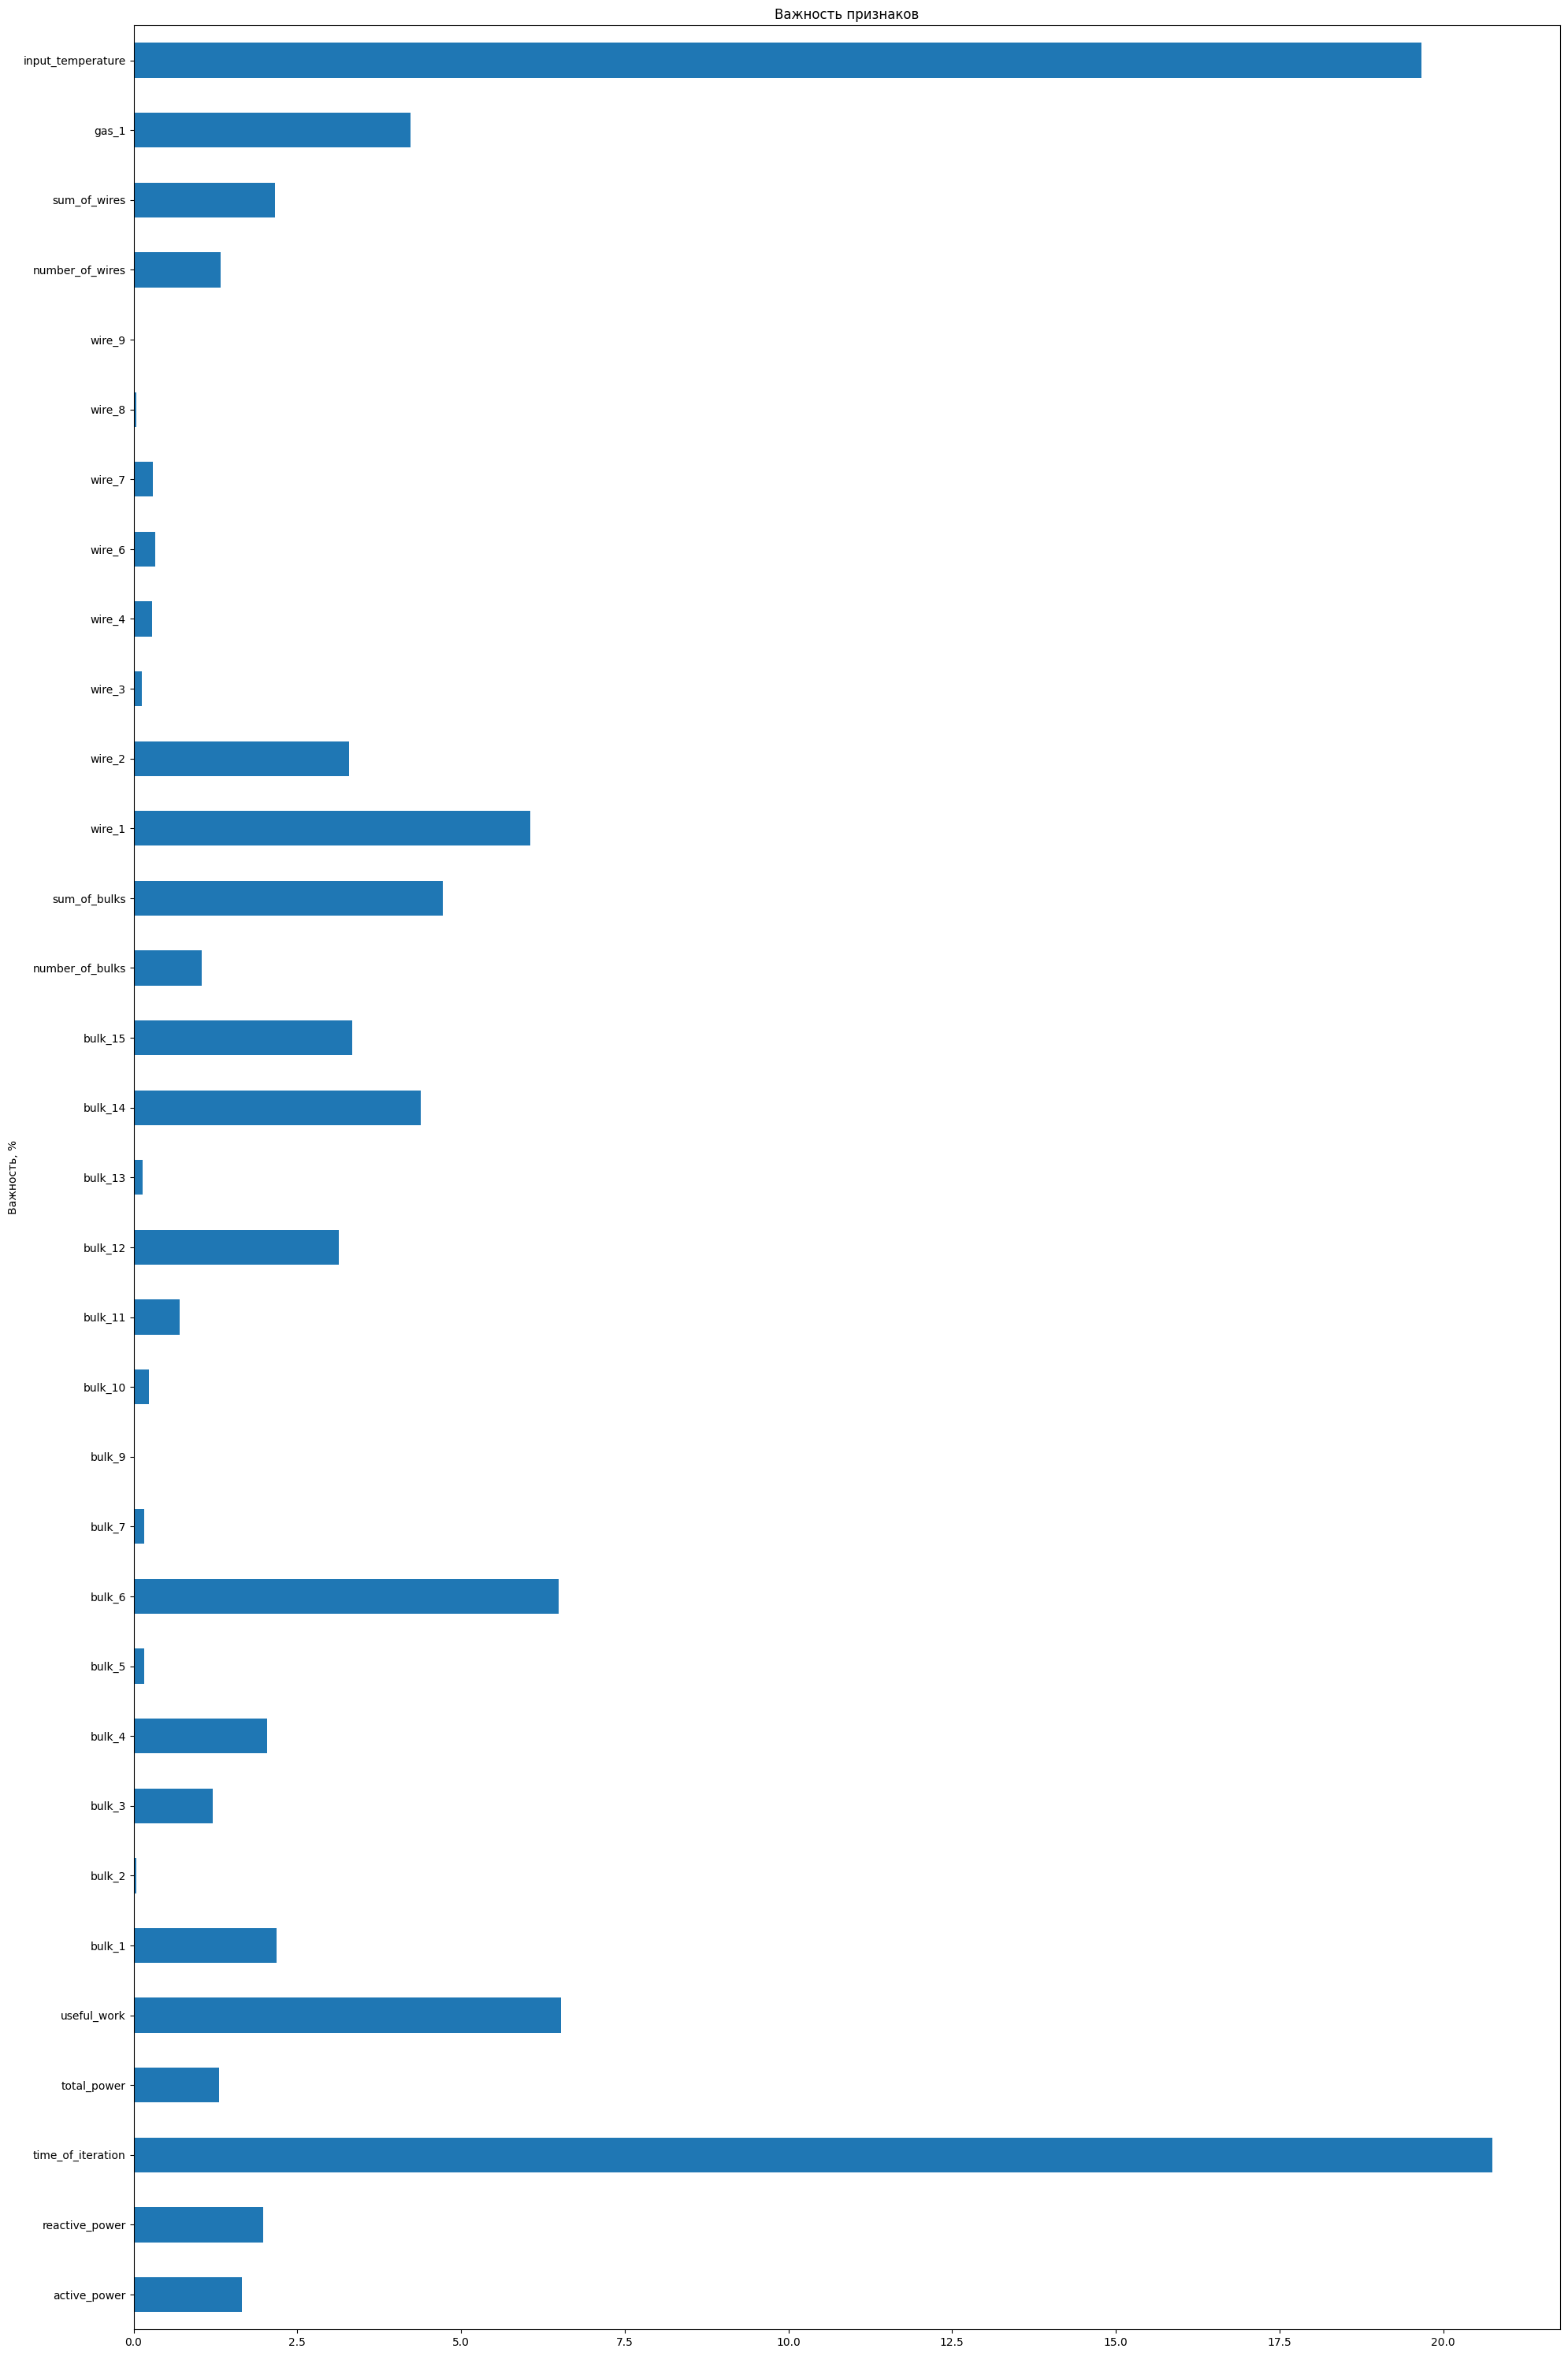

In [98]:
rf_imp = pd.Series(model_boost.get_feature_importance(),
                         features.columns)
fig, ax = plt.subplots(figsize=(20,30))
rf_imp.plot.barh(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

**Вывод**: из диаграммы видно, что наиболее важными признаками являются **входная температура и суммарное время иттераций**. 

**Вывод**: Модель градиентного бустинга **CatBoostRegressor** с параметрами n_estimators = 800, learning_rate = 0.03 и depth = 6, дает оценку качества MAE = 6.2 Время обучения модели - 3 с, время предсказания - 4 мс. 

### 6.3 Модель случайного леса

In [99]:
model = RandomForestRegressor()
grid = {
         'n_estimators': [100, 200, 300],
          'max_depth': [6, 9]
         }
gsearch = GridSearchCV(estimator=model, 
                       cv=5, 
                       param_grid=grid,  
                       scoring=scorer)
gsearch.fit(train_features, train_target)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [6, 9], 'n_estimators': [100, 200, 300]},
             scoring=make_scorer(mae, greater_is_better=False))

In [100]:
gsearch.best_params_

{'max_depth': 9, 'n_estimators': 300}

In [101]:
gsearch.best_score_

-6.464

Определим время предсказания модели. 

In [102]:
%%time
start = time.time()
model_rf = RandomForestRegressor(random_state=111223,max_depth=9, n_estimators=300)
model_rf.fit(train_features, train_target)
end = time.time()
t_rf=round(end-start,2)

CPU times: total: 3.14 s
Wall time: 3.12 s


Определим время обучения модели. 

In [103]:
%%time
start = time.time()
pred_rf=model_rf.predict(train_features)
end = time.time()
t_rf_p=round(end-start,2)

CPU times: total: 78.1 ms
Wall time: 77.5 ms


Рассмотрим теперь важность признаков в полученной модели. Отобразим эти данные на диаграмме. 

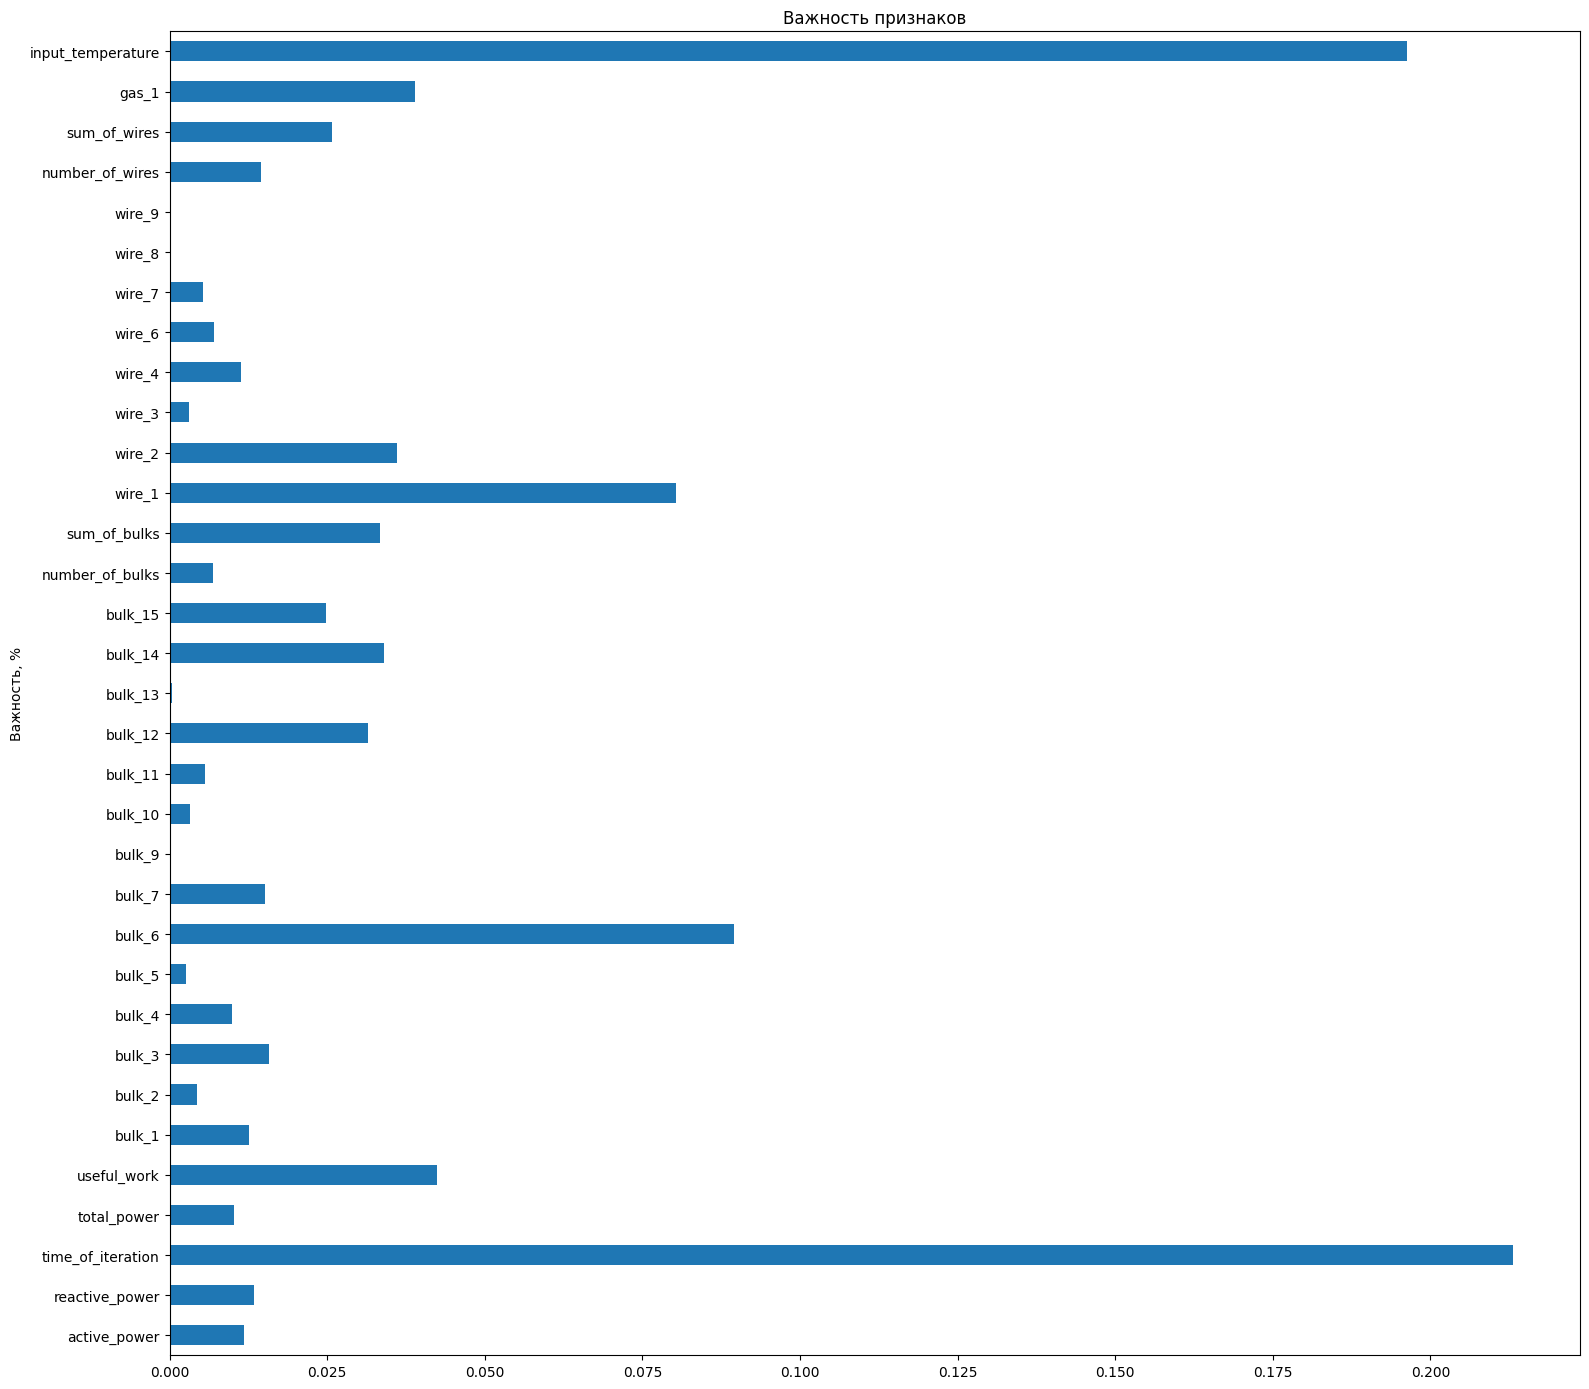

In [104]:
rf_imp = pd.Series(model_rf.feature_importances_,
                         features.columns)
fig, ax = plt.subplots(figsize=(16,14))
rf_imp.plot.barh(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

**Вывод**: модель случайного леса с параметрами max_depth = 9, n_estimators = 300 выдает параметр качества на тестовой выборке MAE 6.4. Модель обучается за 3 с, предсказывает за 70.4. Аналогично градиентному бустингу важнейшими параметрами являются общее время процесса и входная температура. 

**Общий вывод**: таким образом, модель градиентного бустинга по всем параметрам справляется с задачей лучше и будет выбрана в качестве итоговой. 

## 7. Выбор лучшей модели 

Проведем итоговое тестирование выбранной модели на тестовой выборке и измерим полученные параметр качества MAE. 

In [105]:
#Проведем предсказание на тестовой выборке.
predict_boost=model_boost.predict(test_features)
mae(predict_boost, test_target)

6.0

Сравним теперь полученную модель с константной моделью, выдающей среднее значение. 

In [106]:
#Cоздадим константную модель со средним значением
model_dummy = DummyRegressor(strategy="mean")
model_dummy.fit(train_features, train_target)
predictions_dummy = model_dummy.predict(test_features)
mae(predictions_dummy, test_target)

8.13

**Вывод**: таким образом, полученная модель градиентного бустинга выдает параметр качества **MAE = 6** на тестовой выборке, что согласуется с поставленной задачей **MAE <= 6.8**. Также определено, что представленная модель справляется лучше, чем обычная константная модель, параметр качества в которой - 8.13.

## Выводы

Была проведена работа по построению модели машинного обучения по предсказанию выходной температуры в процессе изготовления стали. Для этого были проанализированы исходные данные, проведена их предварительная обработка, введены признаки, необходимые для этого моделирования. Из исходных данных был сформирован общий датафрейм. 

Признаки для обучения модели являлись: активная мощность, пассивная мощность, введенная общая мощность, введенное полное время процесса, полная полезная работа, 3,4,6, 12, 14, 15 - сыпучие материалы, общее количество применных материалов, суммарный объем этих материалов, 1 и 2 проволочные материалы, общее их количество, суммарных их объем, объем применненного газа и входная температура. 

Для построения модели было проведено масштабирование данных, разбиение данных на тестовую и тренировочную выборки в соотношении 1:3. В качестве исходных были выбраны модели - градиентного бустинга СatBoostRegressor и Случайный лес. Обе модели были обучены и проверены с помощью кросс-валидации. 

В ходе обучения были получены две модели: <br>
**CatBoostRegressor** с параметрами **n_estimators = 800, learning_rate = 0.03 и depth = 6**, дает оценку качества MAE = 6.2 Время обучения модели - 2 с, время предсказания - 4.3 мс. <br>
**Cлучайный лес** с параметрами max_depth = 9, n_estimators = 300 выдает параметр качества на тестовой выборке MAE 6.3. Модель обучается за 3 с, предсказывает за 70.4.

Из этих моделей была выбрана наилучшая по всем параметрам - СatBoostRegressor.

В результате ее тестирования на тестовой выборке был получен результат **MAE = 6**, что удовлетворяет поставленным условиям. Результат сравнен с константной моделью, выдающей среднее значение и доказано, что наша модель получает более качественный результат.

Полученная модель может быть использована для прогнозирования выходной температуры стали в технологическом процессе. Это позволяет проводить моделирование данного процесса и сокращать количество итераций, а следовательно и используемой электроэнергии. Тем самым возможно повышение экономичности производства. 